In [1]:
# mapping to CORUM complexes

In [1]:
from altProts_in_communities.utils import *
from altProts_in_communities.network_assembly import *

In [2]:
G_o = pickle.load(open('G_o.pkl', 'rb'))
G_o_edges = pickle.load(open('G_o_edges.pkl', 'rb'))
HCIP_baits = pickle.load(open('HCIP_baits.pkl', 'rb'))

CORUM data source: http://mips.helmholtz-muenchen.de/corum/download/coreComplexes.txt.zip

In [3]:
hgnc_entrez_dict  = {}
hgnc_synonym_dict  = {}
hgnc_id_dict = {}
hgnc_genes = []
with open('hgnc_entrez.txt', 'r') as f:
    for n,l in enumerate (f):
        if n==0:
            #print(l)
            continue
        ls = l.split('\t')
        symbol    = ls[1].strip()
        synonyms  = ls[5].strip()
        entrez_id = ls[6].strip()
        hgnc_id = int(ls[0].strip())
        hgnc_id_dict[hgnc_id] = symbol
        entrez_id_ncbi = ls[7].strip()
        if 'withdrawn' not in symbol:
            #symbol = symbol.split('~')[0]
            hgnc_genes += [symbol]
        if entrez_id != '':
            hgnc_entrez_dict[entrez_id] = symbol
        elif entrez_id_ncbi != '':
            hgnc_entrez_dict[entrez_id_ncbi] = symbol
        if synonyms != '':
            hgnc_synonym_dict.update({x: symbol for x in synonyms.split(', ')})
hgnc_genes = set(hgnc_genes)
hgnc_int_entrez_dict = {int(k) : v for k,v in hgnc_entrez_dict.items()}

import re
corum = []
missing_ids = []
with open('coreComplexes.txt', 'r') as f:
    for n,l in enumerate(f):
        ls = l.split('\t')        
        if n==0:
            fields = [x.replace('"','').strip() for x in ls if x.replace('"','').strip()]
            continue
            
        row = {}
        for n,field in enumerate(fields):
            row[field] = ls[n].strip()
            
        if row['Organism']!='Human': continue

        if row['subunits(Entrez IDs)'] != '':
            entrz_ids = row['subunits(Entrez IDs)'].split(';')
            if any(x=='None' for x in entrz_ids):
                print(row['ComplexName'])
                continue
            row['subunits(Entrez IDs)'] = [int(re.sub("\D", "", x)) for x in entrz_ids]
        if row['Protein complex purification method'] != '':
            row['Protein complex purification method'] = [x.strip() for x in row['Protein complex purification method'].split('|')]
        
        en_ids = []
        for en_id in row['subunits(Entrez IDs)']:
            if en_id not in hgnc_int_entrez_dict.keys():
                missing_ids += [(en_id, row['subunits(Entrez IDs)'])]
                continue
            en_ids += [en_id]
        row['subunits (HGNC)'] = [hgnc_int_entrez_dict[x] for x in en_ids]
        corum.append(row)

E-box sequence-binding complex
28S ribosomal subunit, mitochondrial
55S ribosome, mitochondrial
Spliceosome
core-histone (H2A/H2B/H3/H4)-TDIF2-TDT complex
Anti-Sm protein complex
SMN complex
Cleavage and polyadenylation factor (CPSF)
Histone H3.1 complex
Histone H3.3 complex
DSS1 complex
CENP-A NAC-CAD complex
C complex spliceosome
H2AX complex, isolated from cells without IR exposure
H2AX complex II
Menin-associated histone methyltransferase complex
SMN containing complex
SMN complex
SMN complex
ASF1-interacting protein complex
ASF1-histone containing complex
MYC-DNMT3A-ZBTB17 complex
Ubiquitin E3 ligase (TRAF6, TAB2, MALT1, UEV1A, BCL10)
BCR-ABL (p185 fusion protein)-GRB2 complex
BCR-ABL (p210 fusion protein)-GRB2-SOS1 complex
TIM50-SMN1 complex
SMN1-SIP1-SNRP complex
TLE-Histone H3 complex
MASH1 promoter-coactivator complex
SMN complex (GEMIN2, GEMIN3, GEMIN4, GEMIN5, SMN)
SMN complex (GEMIN2,5, SMN)
HSP90-FKBP38-CAM-Ca(2+) complex
YWHAQ-CALM1-CABIN1 complex
TNF-alpha/NF-kappa B sig

In [4]:
def draw_circ_layout_complx(G, edges_HGNC, baits_HGNC, ax):
    node_colors, edge_colors, edge_widths = color_circ_CORUM_complx(G, edges_HGNC, baits_HGNC)
    layout =  nx.drawing.layout.circular_layout(G.nodes())
    nx.draw_networkx_nodes(G, layout, node_size=1700, node_color=node_colors, edgecolors='#787878', ax=ax)
    nx.draw_networkx_edges(G, layout, edge_color=edge_colors, width=edge_widths, ax=ax)
    nx.draw_networkx_labels(G, layout, ax=ax)

def color_circ_CORUM_complx(complx, ref_net, ref_net_baits, colors = {'bait':'#093e63', 'prey':'#2582c6', 'no_id':'#787878'}, h_edge_width=4, l_edge_width=1):
    edge_colors, node_colors, edge_widths = [], [], []
    overlap = ref_net.intersection(set(frozenset((x)) for x in complx.edges()))
    for ppi in complx.edges():
        edge_color = colors['no_id']
        edge_width = l_edge_width
        if frozenset((ppi)) in overlap:
            edge_color = colors['bait']
            node_color = colors['prey']
            edge_width = h_edge_width
        edge_colors += [edge_color]
        edge_widths += [edge_width]
    
    for p in complx.nodes():
        if p in ref_net_baits:
            node_color = colors['bait']
        elif p in set(x for y in overlap for x in y):
            node_color = colors['prey']
        else:
            node_color = colors['no_id']
        node_colors += [node_color]
    return node_colors, edge_colors, edge_widths

In [5]:
def compute_complex_coverage(subunits, ref_edge_set, baits):
    subunits = set(subunits)
    pairwise_complx = set(frozenset((b, p)) for b, p in itt.permutations(subunits, 2))
    prots_in_comp   = set(x for y in list(ref_edge_set.intersection(pairwise_complx)) for x in y)
    return len(prots_in_comp) / len(subunits)

for complx in corum:
    complx['coverage'] = compute_complex_coverage(complx['subunits (HGNC)'], G_o_edges, HCIP_baits)

for complx in corum:
    overlap_nodes = set(complx['subunits (HGNC)']).intersection(set(G_o.nodes()))
    complx['alt_edges'] = set()
    for node in overlap_nodes:
            first_neibs = G_o.neighbors(node)
            for n in first_neibs:
                if is_alt(n):
                    complx['alt_edges'].add(frozenset((node, n)))

In [6]:
coverage_2baits_complx = []
comrum_2baits = []
for complx in corum:
    bait_overlap = len(HCIP_baits.intersection(set(complx['subunits (HGNC)'])))
    if bait_overlap > 1 and complx['coverage']>0:
        coverage_2baits_complx.append(complx['coverage'])
        comrum_2baits.append(complx)

len(coverage_2baits_complx)

240

In [16]:
# total count of altProt in CORUM complexes
corum_alts = []
for cmplx in comrum_2baits:
    if len(cmplx['alt_edges'])>1:
        alts = [x for y in cmplx['alt_edges'] for x in y if 'IP_' in x]
        corum_alts.extend(alts)
len(set(corum_alts))

33

In [8]:
def get_ordered_baitprey(baitprey):
    baitprey = list(baitprey)
    if is_alt(baitprey[0]):
        baitprey = baitprey[::-1]
    return baitprey

In [9]:
cols = ('ComplexID', 'ComplexName', 'Synonyms', 'subunits(Gene name)', 'subunit coverage', 'altProt edges')

with open('bioplex_tables/Table_EV3.tsv', 'w') as f:
    writer = csv.writer(f, delimiter='\t')
    writer.writerow(cols)
    for cmplx in comrum_2baits:
        alt_edges = '|'.join(['-'.join(get_ordered_baitprey([x.split('|')[0].replace('IP_2287811', 'IP_243680') for x in tuple(edge)])) for edge in list(cmplx['alt_edges'])])
        row = [cmplx[x].replace(';', '|') for x in ['ComplexID', 'ComplexName', 'Synonyms', 'subunits(Gene name)']] + [cmplx['coverage']] + [alt_edges]
        writer.writerow(row)

(array([12., 13.,  8., 16., 13., 11., 39., 29., 17., 82.]),
 array([0.07692308, 0.16923077, 0.26153846, 0.35384615, 0.44615385,
        0.53846154, 0.63076923, 0.72307692, 0.81538462, 0.90769231,
        1.        ]),
 <a list of 10 Patch objects>)

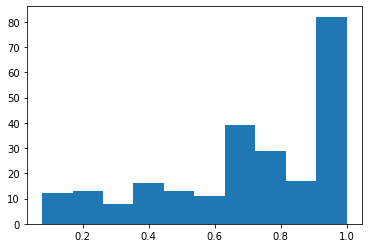

In [10]:
plt.hist(coverage_2baits_complx)

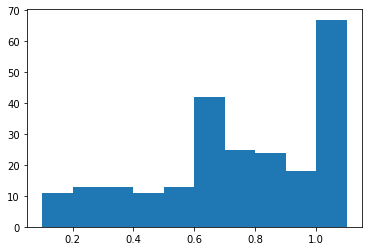

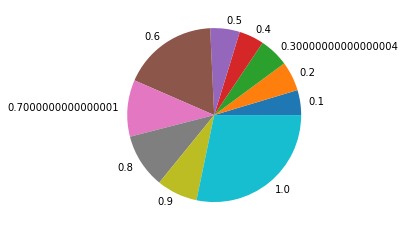

In [11]:
h = plt.hist(coverage_2baits_complx, bins=np.linspace(0.1, 1.1, 11))
cnts, cov, _ = h
plt.show()

plt.pie(cnts, labels=cov[:-1])
plt.savefig('bioplex_figures/CORUM_pie.svg')
plt.show()

In [12]:
def write_corum_edges(edges, alt_edges, cmplx_id):
    with open('bioplex_figures/CORUM/{}_edges.csv'.format(cmplx_id), 'w') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['source', 'target', 'in_bioplex'])
        for e in edges.union(alt_edges):
            in_bioplex = False
            if e in G_o_edges:
                in_bioplex = True
            writer.writerow([*e, in_bioplex])

coverage: 1.0, complex name: Exosome, id: 789
{frozenset({'RNF215|IP_293201', 'EXOSC7'}), frozenset({'RNF215|IP_293201', 'EXOSC3'}), frozenset({'RNF215|IP_293201', 'EXOSC8'})} ['EXOSC10', 'EXOSC9', 'EXOSC2', 'EXOSC7', 'EXOSC6', 'EXOSC8', 'EXOSC4', 'EXOSC5', 'EXOSC3', 'DIS3', 'EXOSC1']


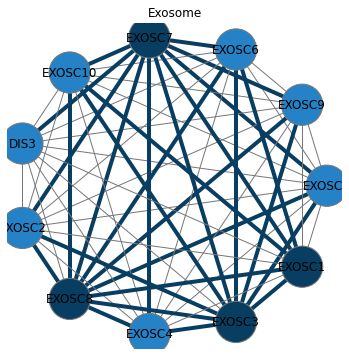

-------------------------
coverage: 1.0, complex name: Exosome, id: 7443
{frozenset({'RNF215|IP_293201', 'EXOSC7'}), frozenset({'RNF215|IP_293201', 'EXOSC3'}), frozenset({'RNF215|IP_293201', 'EXOSC8'})} ['EXOSC10', 'EXOSC9', 'EXOSC2', 'EXOSC7', 'EXOSC6', 'DIS3L', 'EXOSC8', 'MPHOSPH6', 'EXOSC4', 'EXOSC5', 'EXOSC3', 'EXOSC1']


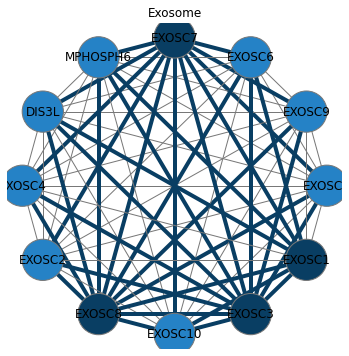

-------------------------
coverage: 1.0, complex name: DISC complex (FAS, FADD, CASP8), id: 5473
{frozenset({'FADD|IP_198808', 'FADD'}), frozenset({'FAS', 'TUBB8P11|IP_673226'})} ['FAS', 'FADD', 'CASP8']


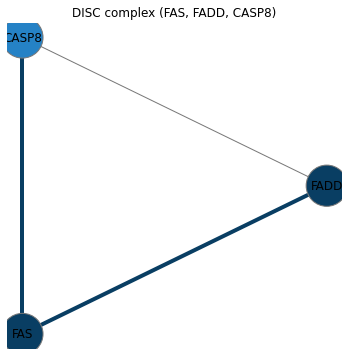

-------------------------
coverage: 1.0, complex name: DISC complex (CD95, FADD, CASP8), id: 5808
{frozenset({'FADD|IP_198808', 'FADD'}), frozenset({'FAS', 'TUBB8P11|IP_673226'})} ['FADD', 'CASP8', 'FAS']


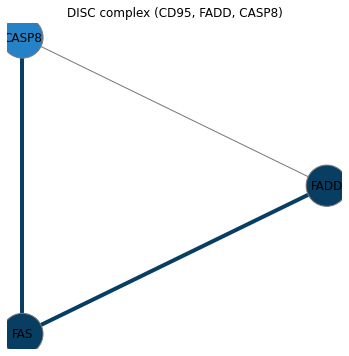

-------------------------
coverage: 1.0, complex name: AP1 adaptor complex, id: 36
{frozenset({'LOC105378807|IP_2391344', 'AP1S2'})} ['AP1G1', 'AP1G2', 'AP1S2', 'AP1S1', 'AP1B1', 'AP1S3', 'AP1M1', 'AP1M2']


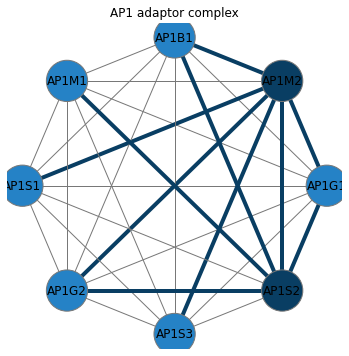

-------------------------
coverage: 1.0, complex name: Gamma-BAR-AP1 complex, id: 144
{frozenset({'LOC105378807|IP_2391344', 'AP1S2'})} ['AP1G1', 'AP1G2', 'AP1S2', 'AP1S1', 'AP1B1', 'AP1AR', 'AP1S3', 'AP1M1', 'AP1M2']


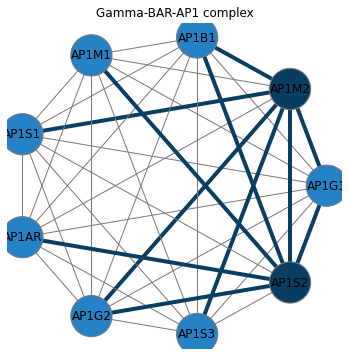

-------------------------
coverage: 1.0, complex name: Ku antigen complex, id: 328
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5']


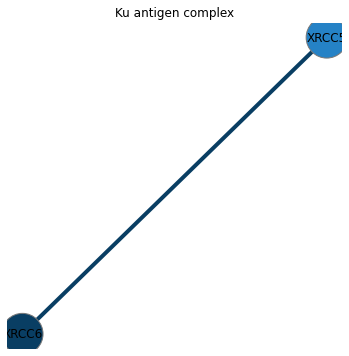

-------------------------
coverage: 1.0, complex name: P-TEFb.1 complex, id: 1079
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'CDK9']


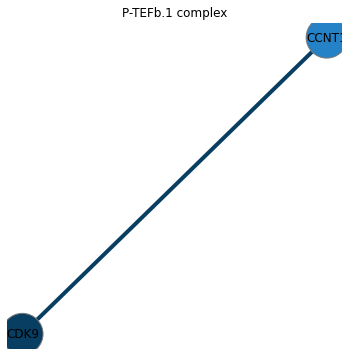

-------------------------
coverage: 1.0, complex name: P-TEFb.2 complex, id: 1080
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT2', 'CDK9']


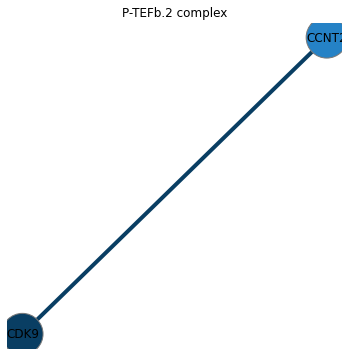

-------------------------
coverage: 1.0, complex name: Septin complex, id: 1345
{frozenset({'SEPT2', 'SEPT7P8|IP_686636'})} ['SEPT2', 'SEPT7', 'SEPT8', 'SEPT11', 'SEPT9']


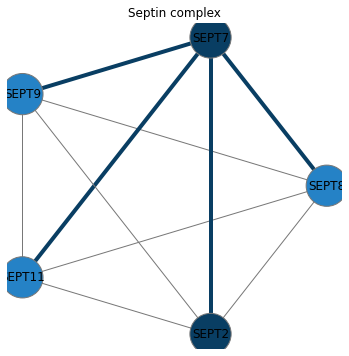

-------------------------
coverage: 1.0, complex name: CyclinD1-CDK4-p21 complex, id: 1634
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND1', 'CDKN1A']


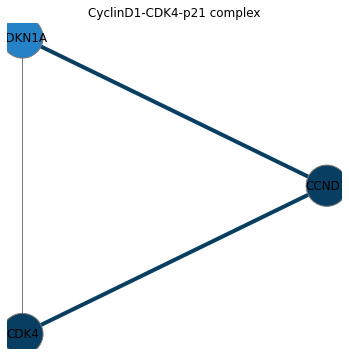

-------------------------
coverage: 1.0, complex name: P-TEFb-7SKRNA-HEXIM1 complex, id: 2602
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'HEXIM1', 'CDK9']


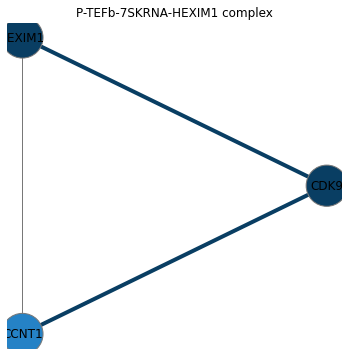

-------------------------
coverage: 1.0, complex name: CCND1-CDK4 complex, id: 3084
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND1']


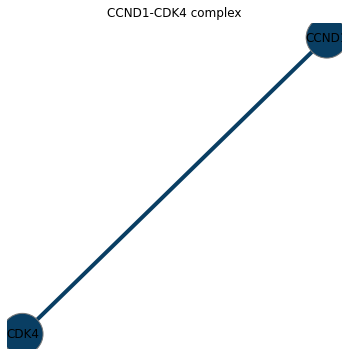

-------------------------
coverage: 1.0, complex name: CCND2-CDK4 complex, id: 3085
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND2']


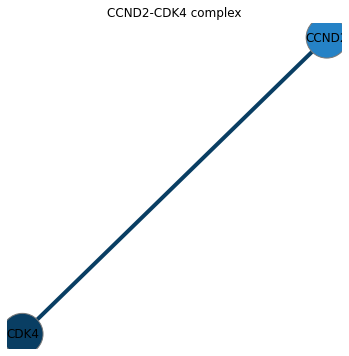

-------------------------
coverage: 1.0, complex name: CCND3-CDK4 complex, id: 3086
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND3']


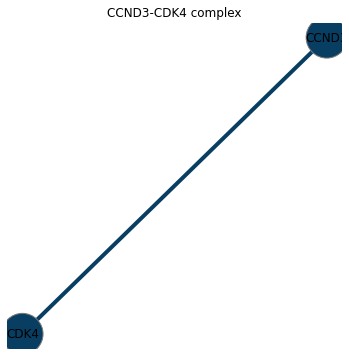

-------------------------
coverage: 1.0, complex name: SMN complex (GEMIN5,4,3), SMN-independent intermediate, id: 3296
{frozenset({'DDX20', 'CARD17|IP_3201973'})} ['GEMIN4', 'GEMIN5', 'DDX20']


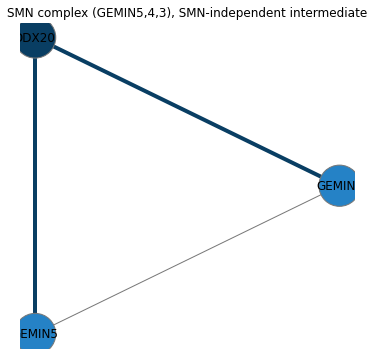

-------------------------
coverage: 1.0, complex name: XRCC6-XRCC5-WRN complex, id: 4082
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'WRN']


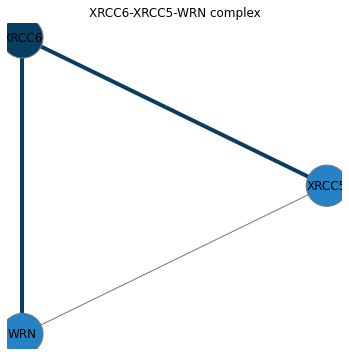

-------------------------
coverage: 1.0, complex name: CyclinD3-CDK4-CDK6 complex, id: 5100
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND3', 'CDK6']


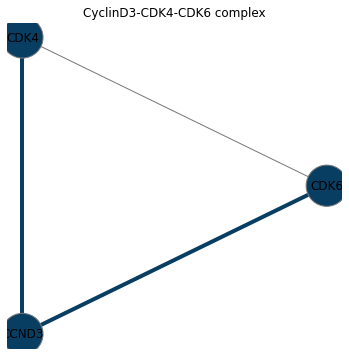

-------------------------
coverage: 1.0, complex name: CyclinD3-CDK4-CDK6-p21 complex, id: 5101
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND3', 'CDKN1A', 'CDK6']


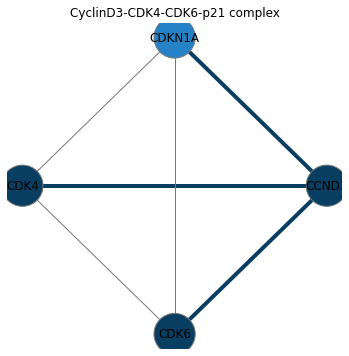

-------------------------
coverage: 1.0, complex name: KICSTOR complex, id: 6754
{frozenset({'AC010395.2|IP_602155', 'ITFG2'})} ['SZT2', 'ITFG2', 'C12orf66', 'KPTN']


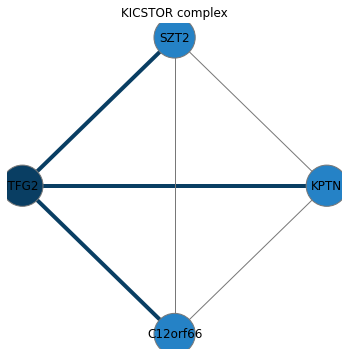

-------------------------
coverage: 1.0, complex name: GATB-GATC-QRSL1 complex, id: 6959
{frozenset({'GATC', 'GATB|IP_618814'})} ['GATC', 'GATB', 'QRSL1']


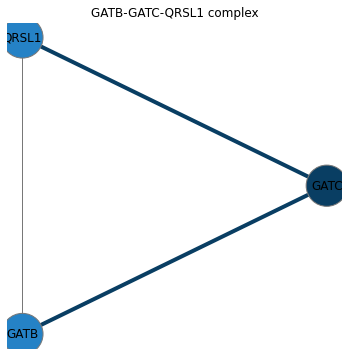

-------------------------
coverage: 1.0, complex name: 7SK RNP complex, id: 7566
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'HEXIM1', 'CDK9', 'LARP7']


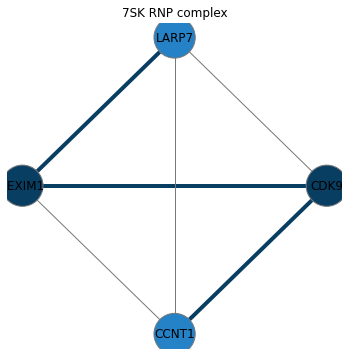

-------------------------
coverage: 0.9375, complex name: 39S ribosomal subunit, mitochondrial, id: 324
{frozenset({'SLC38A10|IP_711690', 'MRPL12'})} ['MRPL33', 'MRPL3', 'MRPL19', 'MRPL12', 'LACTB', 'MRPL28', 'MRPL49', 'MRPL23', 'MRPL51', 'MRPL2', 'MRPL54', 'MRPL14', 'MRPL21', 'MRPL55', 'MRPL10', 'MRPL52', 'MRPL41', 'MRPL50', 'MRPL43', 'MRPL30', 'MRPL24', 'MRPL38', 'MRPL53', 'MRPL48', 'MRPL34', 'MRPL45', 'MRPL32', 'MRPL20', 'MRPL13', 'MRPL9', 'MRPL4', 'MRPL1', 'MRPL37', 'MRPL18', 'MRPL46', 'MRPL44', 'MRPL47', 'MRPL40', 'MRPL17', 'MRPL22', 'MRPL16', 'MRPL39', 'MRPL35', 'MRPL15', 'MRPL36', 'MRPL27', 'MRPL11', 'MRPL42']


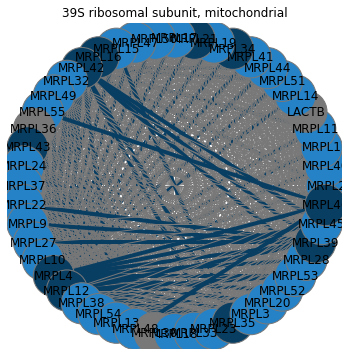

-------------------------
coverage: 0.9090909090909091, complex name: AFF4 super elongation complex (SEC), id: 6084
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['ELL2', 'CCNT1', 'CCNT2', 'MLLT3', 'CDK9', 'AFF1', 'ELL', 'MLLT1', 'EAF1', 'ELL3', 'AFF4']


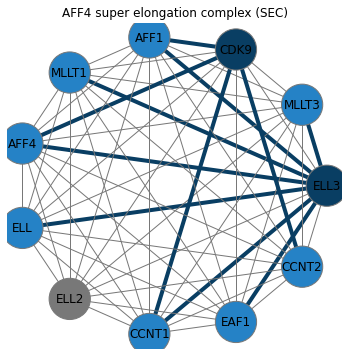

-------------------------
coverage: 0.8666666666666667, complex name: PA28gamma-20S proteasome, id: 194
{frozenset({'PSME3', 'BEND4|IP_117582'})} ['PSMA7', 'PSMB1', 'PSMA1', 'PSMA2', 'PSMA3', 'PSMA4', 'PSMA5', 'PSMB4', 'PSMB6', 'PSMB5', 'PSMB3', 'PSMB2', 'PSMA6', 'PSME3', 'PSMB7']


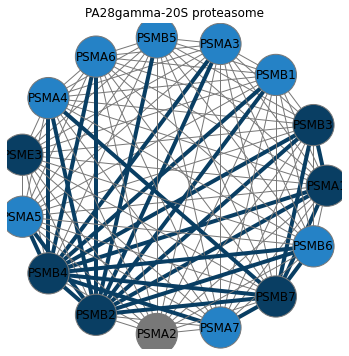

-------------------------
coverage: 0.8461538461538461, complex name: eIF3 complex (EIF3S6, EIF3S5, EIF3S4, EIF3S3, EIF3S6IP, EIF3S2, EIF3S9, EIF3S12,  EIF3S10, EIF3S8,  EIF3S1, EIF3S7, PCID1), id: 1097
{frozenset({'EIF3E', 'EIF3LP2|IP_790907'})} ['EIF3F', 'EIF3D', 'EIF3H', 'EIF3G', 'EIF3J', 'EIF3B', 'EIF3E', 'EIF3I', 'EIF3A', 'EIF3M', 'EIF3C', 'EIF3K', 'EIF3L']


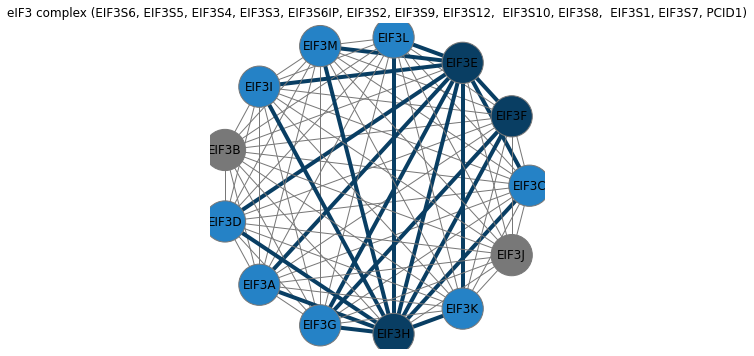

-------------------------
coverage: 0.8, complex name: SMN complex, id: 1745
{frozenset({'DDX20', 'CARD17|IP_3201973'})} ['GEMIN2', 'SNRPA', 'SNRPB', 'GEMIN4', 'SNRPE', 'SNRPF', 'SNRPG', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'SNRPN', 'GEMIN5', 'GEMIN6', 'GEMIN7', 'DDX20']


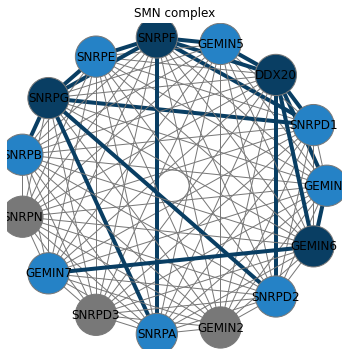

-------------------------
coverage: 0.8, complex name: 53BP1-containing complex, id: 5231
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'RPA2', 'RPA1', 'TP53BP1']


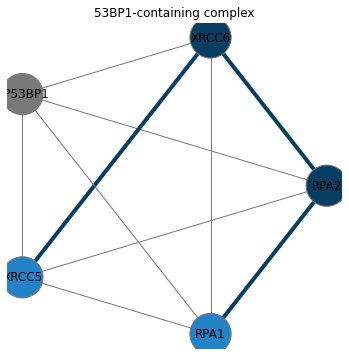

-------------------------
coverage: 0.75, complex name: Cullin-RING E3 ubiquitin ligase complex, id: 6268
{frozenset({'MADD|IP_195391', 'ASB9'}), frozenset({'ASB9P1|IP_736336', 'ASB9'}), frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'CUL5', 'ASB9']


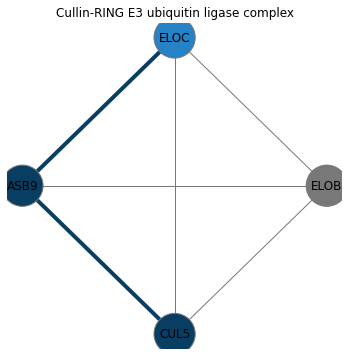

-------------------------
coverage: 0.75, complex name: PKA (RII-alpha and RII-beta)-AKAP5-ADRB1 complex, id: 878
{frozenset({'PRKAR2B', 'PRKAR2B|IP_156019'}), frozenset({'PRKAR2B', 'ATRX|IP_301371'})} ['ADRB1', 'PRKAR2A', 'AKAP5', 'PRKAR2B']


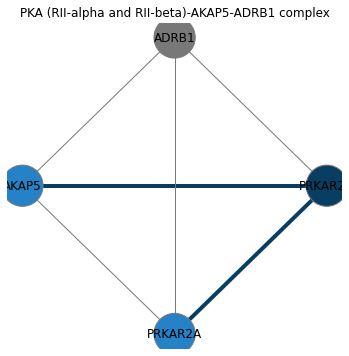

-------------------------
coverage: 0.75, complex name: RING1-Polycomb repressive complex, id: 5513
{frozenset({'AC092329.4|IP_688853', 'PHC1'}), frozenset({'CEPT1|IP_679545', 'PHC1'})} ['CBX4', 'BMI1', 'PHC1', 'RING1']


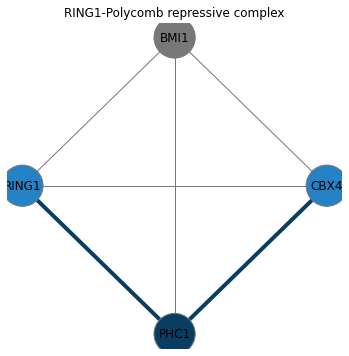

-------------------------
coverage: 0.75, complex name: DISC complex (FAS, FADD, CASP8, CFLAR), membrane-associated, CD95L induced, id: 5799
{frozenset({'FADD|IP_198808', 'FADD'}), frozenset({'FAS', 'TUBB8P11|IP_673226'})} ['CFLAR', 'FAS', 'FADD', 'CASP8']


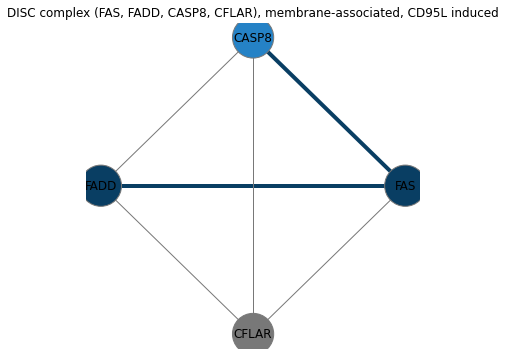

-------------------------
coverage: 0.75, complex name: FAS-FADD-CASP8-CASP10 complex, id: 5859
{frozenset({'FADD|IP_198808', 'FADD'}), frozenset({'FAS', 'TUBB8P11|IP_673226'})} ['FAS', 'FADD', 'CASP8', 'CASP10']


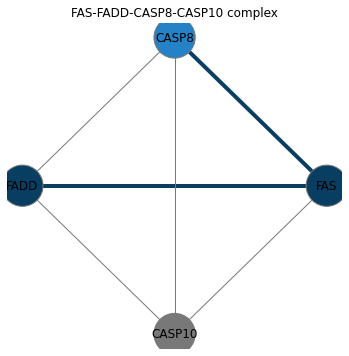

-------------------------
coverage: 0.75, complex name: Cell cycle kinase complex CDK4, id: 312
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'PCNA', 'CCND1', 'CDKN1A']


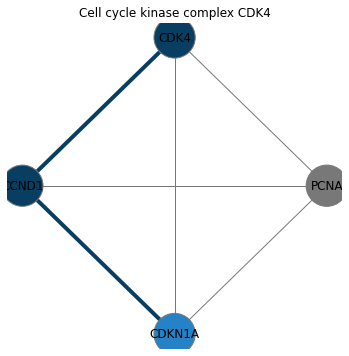

-------------------------
coverage: 0.75, complex name: BRD4 complex, id: 2600
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['MED14', 'CCNT1', 'BRD4', 'MED24', 'CDK9', 'MED1', 'MED12', 'MED17']


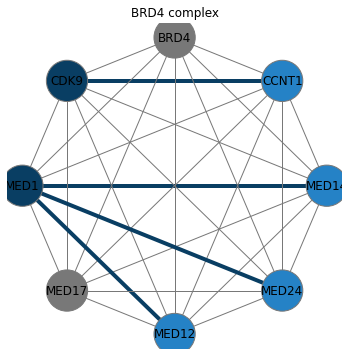

-------------------------
coverage: 0.75, complex name: WRN-Ku70-Ku80-PARP1 complex, id: 5235
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['PARP1', 'XRCC6', 'XRCC5', 'WRN']


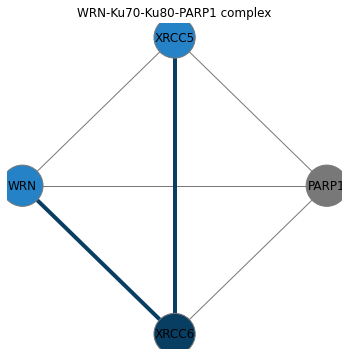

-------------------------
coverage: 0.75, complex name: MNK1-eIF4F complex, id: 5253
{frozenset({'EIF4A1', 'EIF4A1P7|IP_758374'})} ['EIF4E', 'EIF4A1', 'EIF4G1', 'MKNK1']


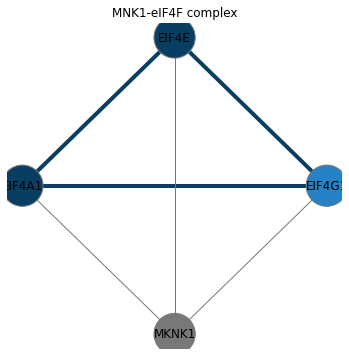

-------------------------
coverage: 0.7142857142857143, complex name: TERF2-RAP1 complex, id: 2766
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'MRE11', 'TERF2', 'RAD50', 'TINF2', 'TERF2IP']


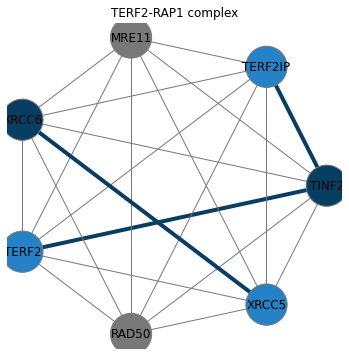

-------------------------
coverage: 0.6923076923076923, complex name: Polycomb repressive complex 1 (PRC1, hPRC-H), id: 116
{frozenset({'AC092329.4|IP_688853', 'PHC1'}), frozenset({'CEPT1|IP_679545', 'PHC1'})} ['CBX4', 'SMARCA5', 'HSPA1A', 'YY1', 'BMI1', 'PHC1', 'RING1', 'CBX2', 'PHC2', 'PHC3', 'SCMH1', 'RNF2', 'CBX8']


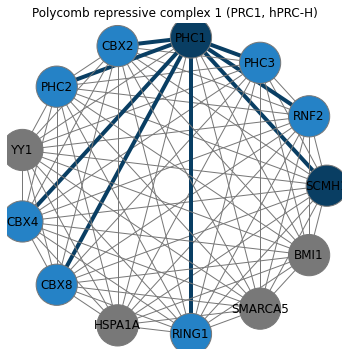

-------------------------
coverage: 0.6666666666666666, complex name: AMY-1-S-AKAP84-RII-beta complex, id: 519
{frozenset({'PRKAR2B', 'PRKAR2B|IP_156019'}), frozenset({'PRKAR2B', 'ATRX|IP_301371'})} ['PRKAR2B', 'AKAP1', 'MYCBP']


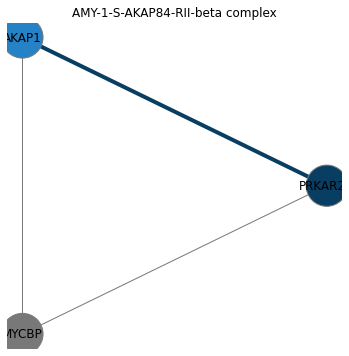

-------------------------
coverage: 0.6666666666666666, complex name: BMI1-HPH1-HPH2 complex, id: 5518
{frozenset({'AC092329.4|IP_688853', 'PHC1'}), frozenset({'CEPT1|IP_679545', 'PHC1'})} ['BMI1', 'PHC1', 'PHC2']


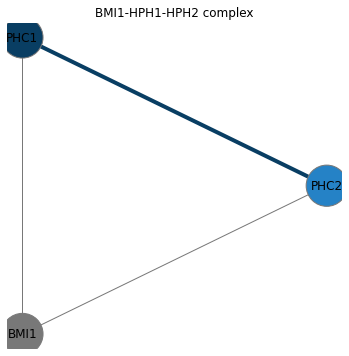

-------------------------
coverage: 0.6666666666666666, complex name: FAS-FADD-CASP10 complex, id: 5861
{frozenset({'FADD|IP_198808', 'FADD'}), frozenset({'FAS', 'TUBB8P11|IP_673226'})} ['FAS', 'FADD', 'CASP10']


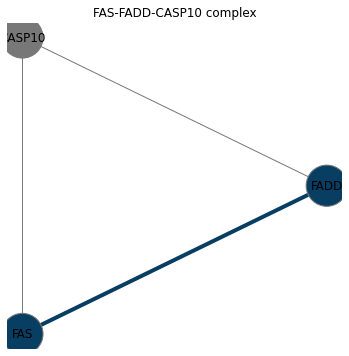

-------------------------
coverage: 0.6666666666666666, complex name: Ku antigen-NARG1 complex, id: 95
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'NAA15']


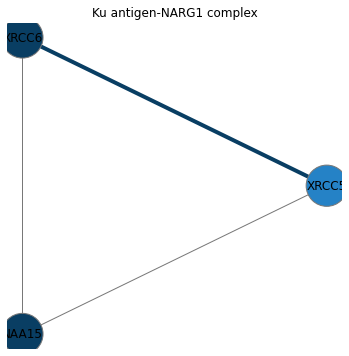

-------------------------
coverage: 0.6666666666666666, complex name: DNA-PK-Ku complex, id: 322
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'PRKDC']


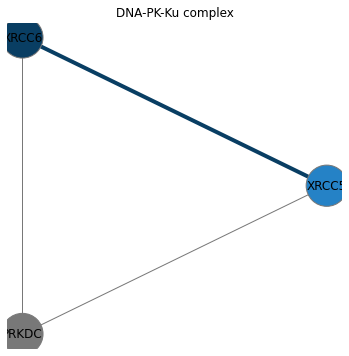

-------------------------
coverage: 0.6666666666666666, complex name: PCNA-KU antigen complex, id: 1092
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['PCNA', 'XRCC6', 'XRCC5']


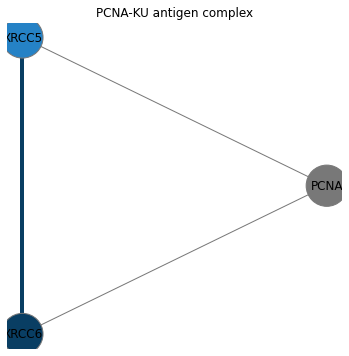

-------------------------
coverage: 0.6666666666666666, complex name: TRF2-Ku complex, id: 1220
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'TERF2']


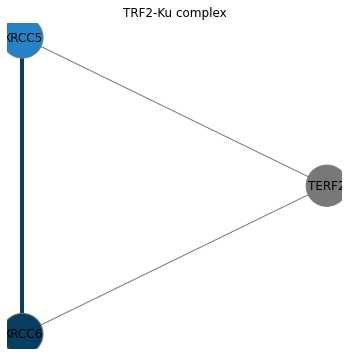

-------------------------
coverage: 0.6666666666666666, complex name: Transcription elongation factor complex (SUPT5H, CDK9, CCNT1), id: 2603
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['SUPT5H', 'CCNT1', 'CDK9']


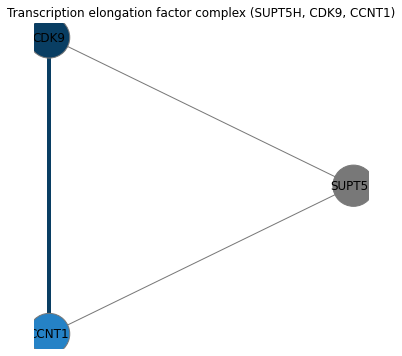

-------------------------
coverage: 0.6666666666666666, complex name: P-TEFb-SKP2 complex, id: 2604
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'CDK9', 'SKP2']


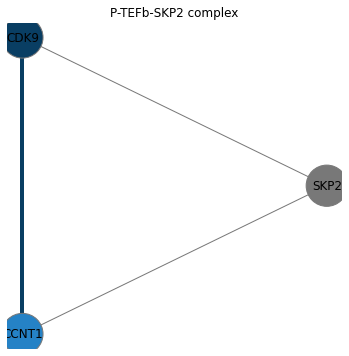

-------------------------
coverage: 0.6666666666666666, complex name: CCNT1- CDK9-GRN complex, id: 2605
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'GRN', 'CDK9']


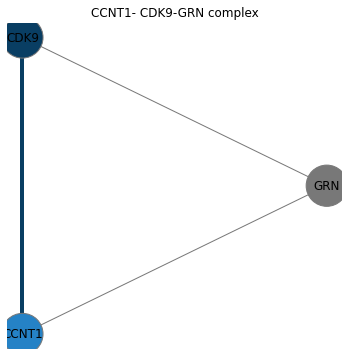

-------------------------
coverage: 0.6666666666666666, complex name: BRD4-P-TEFb complex, id: 2875
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'BRD4', 'CDK9']


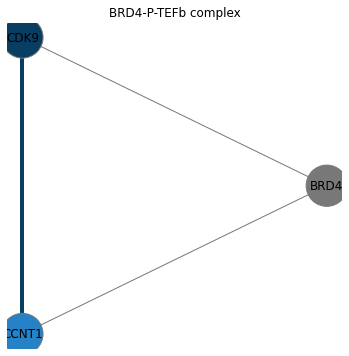

-------------------------
coverage: 0.6666666666666666, complex name: BRD4-P-TEFb complex, id: 2877
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'BRD4', 'CDK9']


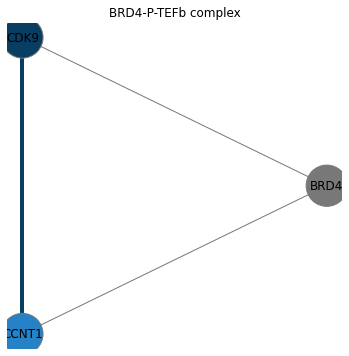

-------------------------
coverage: 0.6666666666666666, complex name: Ku antigen-YY1-alphaMyHC promoter complex, id: 2918
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'YY1']


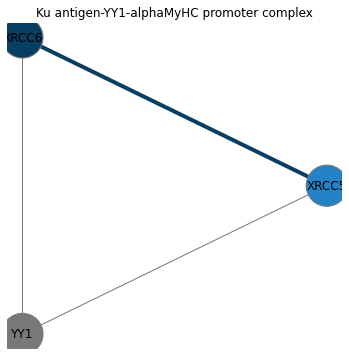

-------------------------
coverage: 0.6666666666666666, complex name: p34(SEI-1)-CDK4-CyclinD2 complex, id: 5107
{frozenset({'HSP90AB6P|IP_755625', 'CDK4'})} ['CDK4', 'CCND2', 'SERTAD1']


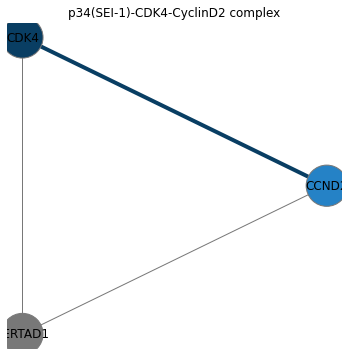

-------------------------
coverage: 0.6666666666666666, complex name: E2F1-p107-cyclinA complex, id: 5144
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['CCNA2', 'RBL1', 'E2F1']


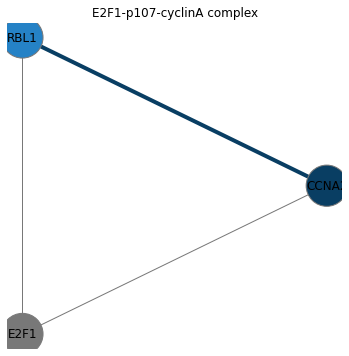

-------------------------
coverage: 0.6666666666666666, complex name: Ku-ORC complex, id: 5251
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['ORC4', 'XRCC6', 'XRCC5', 'ORC2', 'ORC3', 'ORC6']


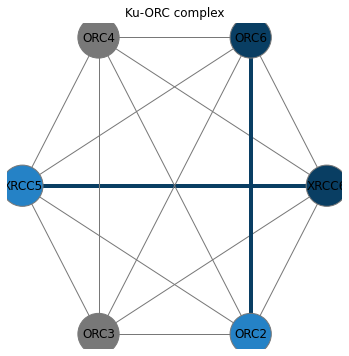

-------------------------
coverage: 0.6666666666666666, complex name: DEAF1- complex, id: 6310
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['DEAF1', 'XRCC6', 'XRCC5']


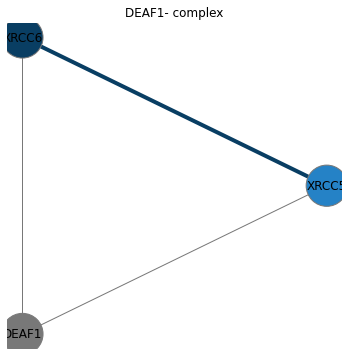

-------------------------
coverage: 0.6666666666666666, complex name: DKK1-KREMEN1-LRP6 complex, id: 7544
{frozenset({'LOC102725180|IP_3412977', 'DKK1'})} ['LRP6', 'DKK1', 'KREMEN1']


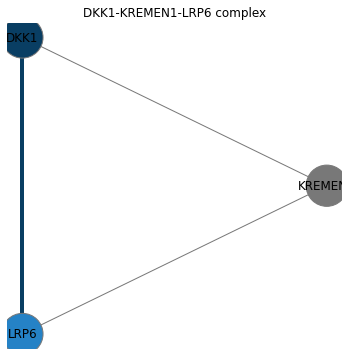

-------------------------
coverage: 0.6363636363636364, complex name: 17S U2 snRNP, id: 2755
{frozenset({'HSPD1', 'HSPD1P7|IP_658154'}), frozenset({'HSPD1P4|IP_761691', 'HSPD1'}), frozenset({'GIMAP1|IP_158762', 'SNRPA1'}), frozenset({'HSPD1P10|IP_591826', 'HSPD1'}), frozenset({'SNCAIP|IP_130051', 'HSPD1'}), frozenset({'SNRPA1', 'AL078621.1|IP_637160'}), frozenset({'HSPD1P1|IP_603739', 'HSPD1'})} ['U2SURP', 'DHX15', 'SF3B1', 'DNAJC8', 'SMNDC1', 'SNRPB2', 'SNRPA1', 'HSPD1', 'SNRPB', 'U2AF2', 'SNRPE', 'SNRPF', 'SNRPG', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'U2AF1', 'SRSF1', 'SF3A3', 'TRAP1', 'SF3B2', 'SF3B3', 'SF3B4', 'SF3A2', 'SF3A1', 'DDX46', 'PHF5A', 'CHERP', 'RBM17', 'SF3B5', 'HMG20B', 'PUF60', 'SF3B6']


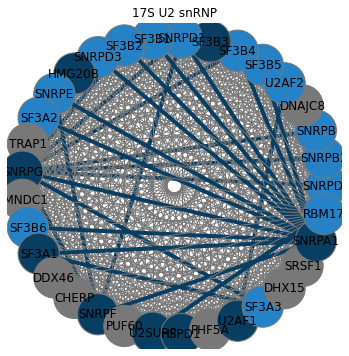

-------------------------
coverage: 0.6, complex name: Ubiquitin E3 ligase (ASB1, TCEB1, TCEB2, CUL5, RNF7), id: 208
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'CUL5', 'RNF7', 'ASB1']


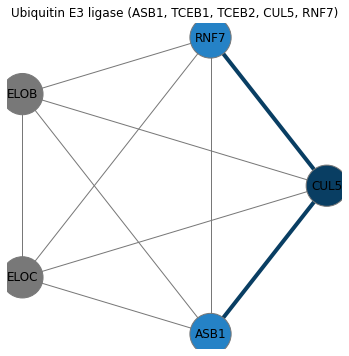

-------------------------
coverage: 0.6, complex name: Ubiquitin E3 ligase (ASB6, TCEB1, TCEB2, CUL5, RNF7), id: 209
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'CUL5', 'ASB6', 'RNF7']


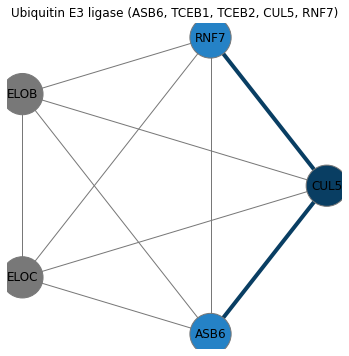

-------------------------
coverage: 0.6, complex name: Ubiquitin E3 ligase (ASB7, TCEB1, TCEB2, CUL5, RNF7), id: 210
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'CUL5', 'ASB7', 'RNF7']


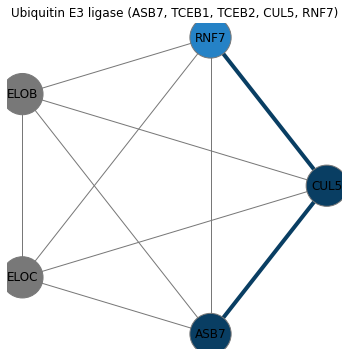

-------------------------
coverage: 0.5714285714285714, complex name: DNA double-strand break end-joining complex, id: 1189
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['NBN', 'XRCC6', 'XRCC5', 'LIG4', 'MRE11', 'XRCC4', 'RAD50']


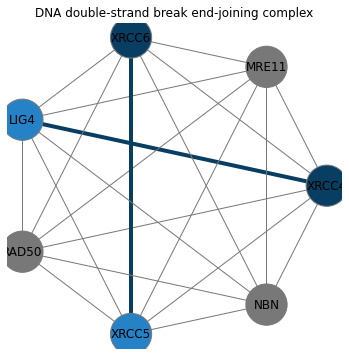

-------------------------
coverage: 0.5384615384615384, complex name: HES1 promoter-Notch enhancer complex, id: 2639
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'POLR2A', 'NOTCH1', 'CDK8', 'CDK7', 'CDK9', 'RBPJ', 'EP300', 'MED1', 'SUPT6H', 'MAML1', 'INPP5K', 'SUPT16H']


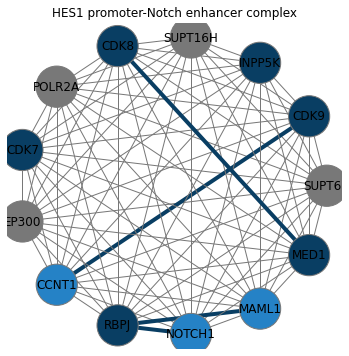

-------------------------
coverage: 0.5, complex name: GALNS-lysosomal hydrolase 1.27 MDa complex, id: 1379
{frozenset({'GLB1', 'GLB1|IP_101889'})} ['CTSA', 'GLB1', 'GALNS', 'NEU1']


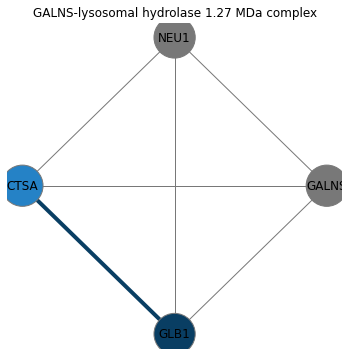

-------------------------
coverage: 0.5, complex name: Vigilin-DNA-PK-Ku antigen complex, id: 1571
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'PRKDC', 'HDLBP']


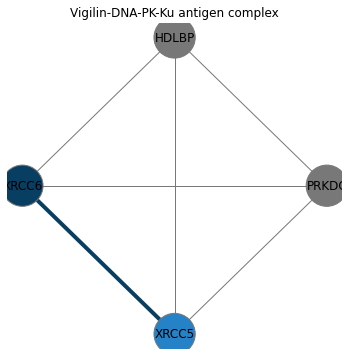

-------------------------
coverage: 0.5, complex name: PPP4C-PPP4R2-Gemin3-Gemin4 complex, id: 1750
{frozenset({'DDX20', 'CARD17|IP_3201973'})} ['GEMIN4', 'PPP4C', 'PPP4R2', 'DDX20']


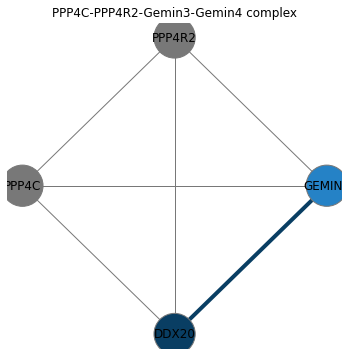

-------------------------
coverage: 0.5, complex name: P-TEFb-BRD4-TRAP220 complex, id: 2601
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'BRD4', 'CDK9', 'MED1']


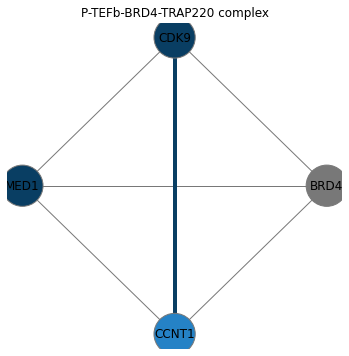

-------------------------
coverage: 0.5, complex name: MGC1-DNA-PKcs-Ku complex, id: 5176
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'PRKDC', 'MDC1']


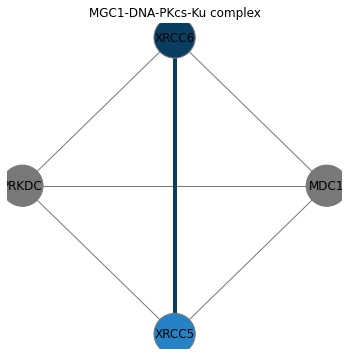

-------------------------
coverage: 0.5, complex name: DNA-PK-Ku-eIF2-NF90-NF45 complex, id: 5183
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['EIF2S1', 'XRCC6', 'XRCC5', 'EIF2S2', 'EIF2S3', 'PRKDC', 'ILF2', 'ILF3']


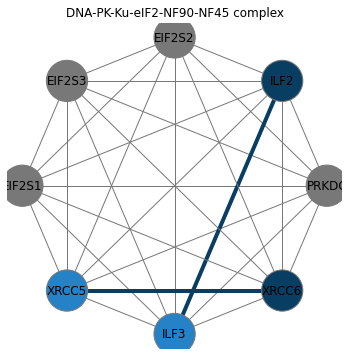

-------------------------
coverage: 0.5, complex name: Dysbindin 1-A-DNA-PK-complex, id: 7217
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'PRKDC', 'DTNBP1']


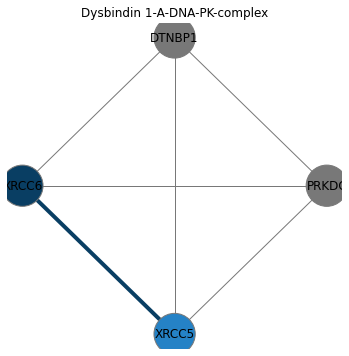

-------------------------
coverage: 0.42857142857142855, complex name: Arp2/3 protein complex, id: 27
{frozenset({'AC093157.1|IP_081175', 'ARPC1B'})} ['ARPC1B', 'ARPC2', 'ARPC3', 'ARPC5', 'ARPC4', 'ACTR3', 'ACTR2']


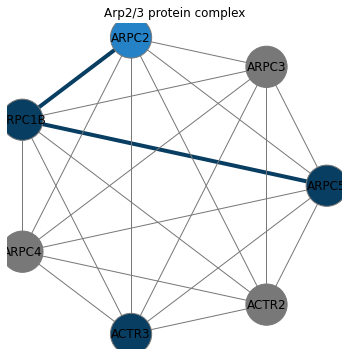

-------------------------
coverage: 0.4, complex name: CDC5L complex, id: 1183
{frozenset({'SNRPA1', 'AL078621.1|IP_637160'}), frozenset({'GIMAP1|IP_158762', 'SNRPA1'})} ['SFI1', 'PPM1D', 'PLRG1', 'SF3B1', 'BCAS2', 'SNRPA', 'SNRPA1', 'HSPA8', 'TOP2A', 'TCF4', 'SFPQ', 'RBMX', 'PPP1CA', 'SNRPD1', 'SNRPD2', 'SNRPD3', 'PRKDC', 'SRSF2', 'SRSF1', 'ILF2', 'SF3B2', 'DYNC1H1', 'SF3B4', 'BZW1', 'SRRM1', 'GCN1', 'CDC5L', 'CWC15', 'PRPF19', 'SCAF8']


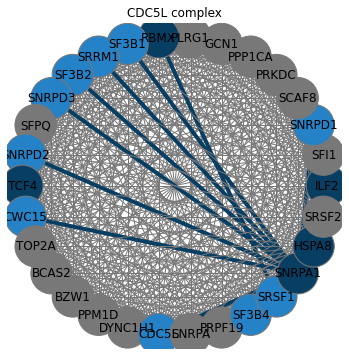

-------------------------
coverage: 0.4, complex name: SRm160/300 complex, id: 1261
{frozenset({'SNRPA1', 'AL078621.1|IP_637160'}), frozenset({'GIMAP1|IP_158762', 'SNRPA1'})} ['SNRNP70', 'SNRPA1', 'TRA2B', 'SRRM1', 'SRRM2']


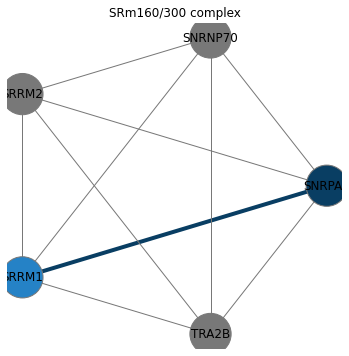

-------------------------
coverage: 0.4, complex name: Ubiquitin E3 ligase (ASB2, TCEB1, TCEB2, CUL5, RNF7), id: 207
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'CUL5', 'ASB2', 'RNF7']


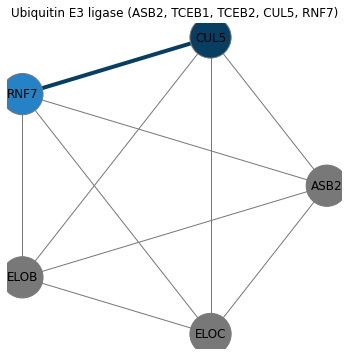

-------------------------
coverage: 0.4, complex name: Ubiquitin E3 ligase (ASB12, TCEB1, TCEB2, CUL5, RNF7), id: 211
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['ELOC', 'ELOB', 'ASB12', 'CUL5', 'RNF7']


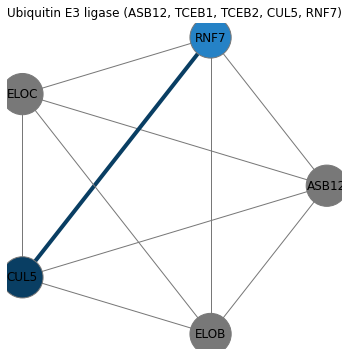

-------------------------
coverage: 0.4, complex name: Ubiquitin E3 ligase (WSB1, TCEB1, TCEB2, CUL5, RBX1), id: 214
{frozenset({'ELOCP31|IP_762570', 'CUL5'})} ['RBX1', 'ELOC', 'ELOB', 'CUL5', 'WSB1']


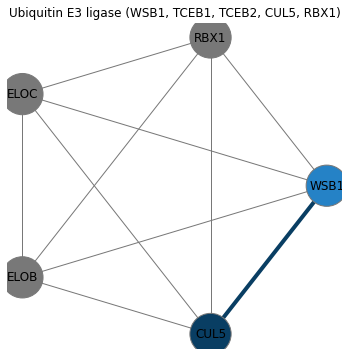

-------------------------
coverage: 0.4, complex name: NCOA6-DNA-PK-Ku-PARP1 complex, id: 5179
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['PARP1', 'XRCC6', 'XRCC5', 'PRKDC', 'NCOA6']


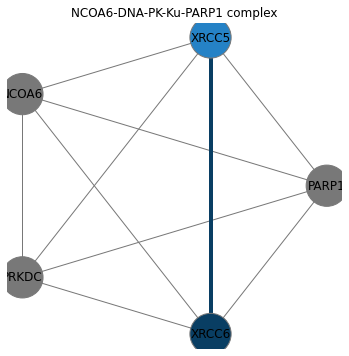

-------------------------
coverage: 0.3333333333333333, complex name: Dynein-2 complex, cytoplasmic, id: 6236
{frozenset({'CCT6P4|IP_620044', 'WDR34'}), frozenset({'CASR|IP_108384', 'WDR34'})} ['DYNLT3', 'DYNLL1', 'DYNLT1', 'NUDCD3', 'DYNC2H1', 'DYNC2LI1', 'DYNLRB2', 'WDR60', 'TCTEX1D2', 'WDR34', 'DYNLL2', 'DYNLRB1']


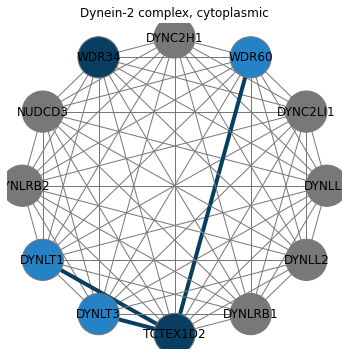

-------------------------
coverage: 0.3333333333333333, complex name: POLR2A-CCNT1-CDK9-NCL-LEM6-CPSF2 complex, id: 2599
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNT1', 'NCL', 'POLR2A', 'CDK9', 'CPSF2', 'PPARGC1A']


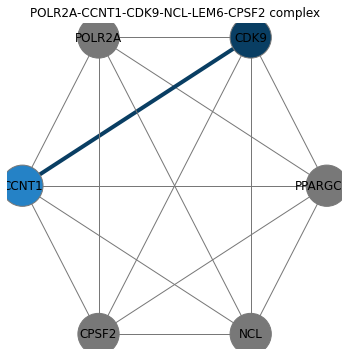

-------------------------
coverage: 0.3333333333333333, complex name: DHX9-ADAR-vigilin-DNA-PK-Ku antigen complex, id: 3102
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'XRCC5', 'ADAR', 'PRKDC', 'HDLBP', 'DHX9']


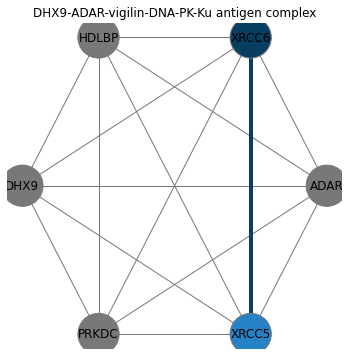

-------------------------
coverage: 0.3173076923076923, complex name: Nop56p-associated pre-rRNA complex, id: 3055
{frozenset({'RPL23AP29|IP_637308', 'RPL28'}), frozenset({'AL133163.1|IP_747029', 'RPLP0'}), frozenset({'RPS2', 'AC004706.3|IP_250569'}), frozenset({'RPS2', 'AL096701.1|IP_651189'}), frozenset({'RPLP0P2|IP_775646', 'RPLP0'}), frozenset({'RPS2', 'AL139100.1|IP_592636'}), frozenset({'NPM1', 'NPM1P52|IP_570964'}), frozenset({'RPL18', 'BEND4|IP_117582'}), frozenset({'EEF1A1P4|IP_762589', 'EEF1A1'}), frozenset({'EEF1A1', 'EEF1A1P11|IP_672870'}), frozenset({'EEF1A1', 'EEF1A1P22|IP_737074'}), frozenset({'EEF1A1', 'EEF1A1P8|IP_623047'}), frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'EEF1A1', 'EEF1A1P24|IP_624363'})} ['NOP56', 'RSL1D1', 'SLC25A5', 'RPLP1', 'RPLP2', 'RPLP0', 'NPM1', 'RPS17', 'HNRNPA1', 'TOP1', 'EEF2', 'RPS2', 'HIST1H1D', 'RPL35A', 'RPL7', 'RPL17', 'NCL', 'FBL', 'RPS12', 'U2AF2', 'RPL13', 'RPL10', 'RPL12', 'RPL9', 'RPL22', 'RPL4', 'SRP14', 'RPL3', 'RPL13A', 'R

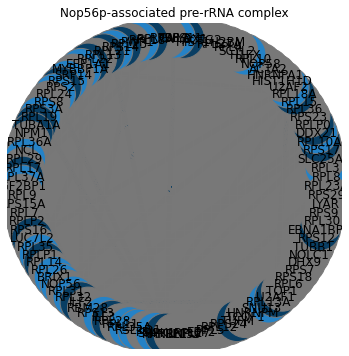

-------------------------
coverage: 0.2857142857142857, complex name: Rap1 complex, id: 1193
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['PARP1', 'XRCC6', 'XRCC5', 'MRE11', 'TERF2', 'RAD50', 'TERF2IP']


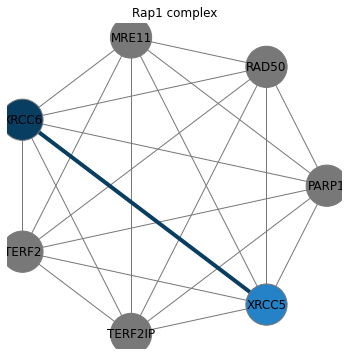

-------------------------
coverage: 0.24, complex name: TRBP containing complex (DICER, RPL7A, EIF6, MOV10 and subunits of the 60S ribosomal particle), id: 5380
{frozenset({'RPL23AP29|IP_637308', 'RPL28'})} ['RPLP1', 'RPLP2', 'RPL35A', 'RPL7', 'RPL13', 'RPL12', 'RPL21', 'RPL28', 'RPL34', 'RPL14', 'EIF6', 'RPL15', 'RPL27', 'RPL37A', 'RPL7A', 'RPL30', 'RPL10A', 'RPL32', 'RPL11', 'RPL19', 'RPL18A', 'MOV10', 'RSL24D1', 'DICER1', 'RPL36']


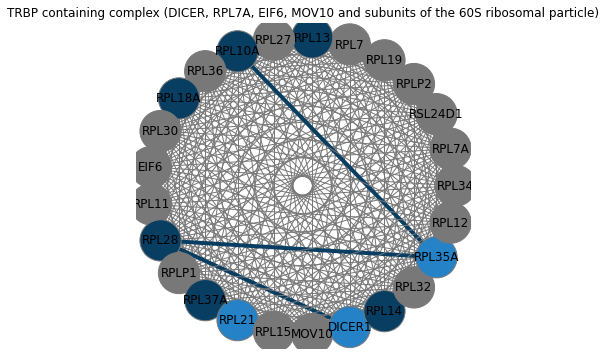

-------------------------
coverage: 0.23076923076923078, complex name: RC complex during S-phase of cell cycle, id: 1004
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['PARP1', 'POLA1', 'TOP1', 'RPA2', 'LIG1', 'CCNA2', 'CDK2', 'RPA1', 'POLD1', 'RPA3', 'RFC2', 'RFC1', 'POLE']


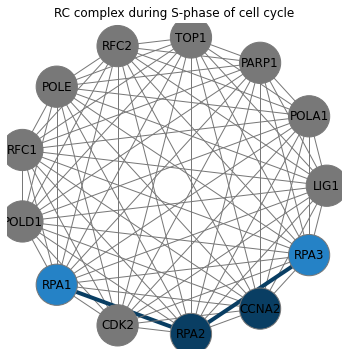

-------------------------
coverage: 0.23076923076923078, complex name: RC complex during G2/M-phase of cell cycle, id: 1005
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['CDK1', 'PARP1', 'POLA1', 'TOP1', 'CCNB1', 'RPA2', 'CCNA2', 'RPA1', 'POLD1', 'RPA3', 'RFC2', 'RFC1', 'POLE']


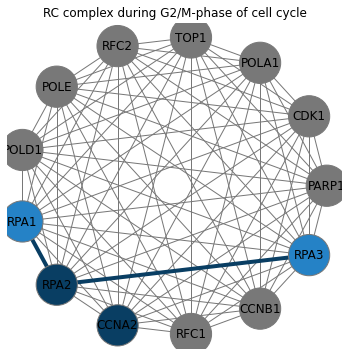

-------------------------
coverage: 0.2222222222222222, complex name: HEXIM1-DNA-PK-paraspeckle components-ribonucleoprotein complex, id: 7285
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['HEXIM1', 'XRCC6', 'XRCC5', 'SFPQ', 'MATR3', 'PRKDC', 'NONO', 'PSPC1', 'RBM14-RBM4']


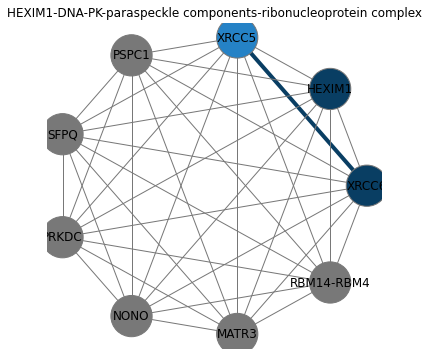

-------------------------
coverage: 0.2, complex name: SMN-PolII-RHA complex, id: 1749
{frozenset({'DDX20', 'CARD17|IP_3201973'})} ['GEMIN2', 'SNRPB2', 'SNRPB', 'TBP', 'POLR2A', 'GEMIN4', 'SNRPN', 'GTF2B', 'DHX9', 'DDX20']


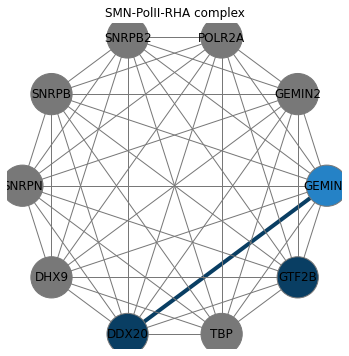

-------------------------
coverage: 0.2, complex name: SELK multiprotein complex, id: 6131
{frozenset({'VCP', 'EEA1|IP_765964'})} ['RPN1', 'RPN2', 'CANX', 'DDOST', 'STT3A', 'VCP', 'SELENOS', 'DERL1', 'DERL2', 'SELENOK']


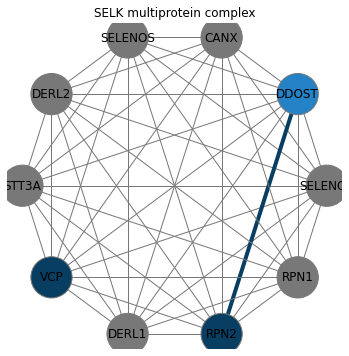

-------------------------
coverage: 0.1625, complex name: Ribosome, cytoplasmic, id: 306
{frozenset({'RPL23AP29|IP_637308', 'RPL28'}), frozenset({'AL133163.1|IP_747029', 'RPLP0'}), frozenset({'RPS2', 'AC004706.3|IP_250569'}), frozenset({'RPS2', 'AL096701.1|IP_651189'}), frozenset({'RPLP0P2|IP_775646', 'RPLP0'}), frozenset({'RPSA', 'RPSAP54|IP_755938'}), frozenset({'RPS2', 'AL139100.1|IP_592636'}), frozenset({'RPL18', 'BEND4|IP_117582'}), frozenset({'RPSAP2|IP_597202', 'RPSA'})} ['RPLP1', 'RPLP2', 'RPLP0', 'RPS17', 'RPSA', 'RPS2', 'RPL35A', 'RPL7', 'RPL17', 'RPS4Y1', 'RPS3', 'RPS12', 'RPL13', 'RPL10', 'RPL12', 'RPL9', 'RPL22', 'RPL4', 'RPS19', 'RPL3', 'RPL13A', 'RPS27', 'RPL35', 'RPL27A', 'RPL5', 'RPL21', 'RPL28', 'RPS9', 'RPS5', 'RPS10', 'RPL29', 'RPL34', 'RPL14', 'RPS20', 'RPS3A', 'RPL26', 'RPL15', 'RPL27', 'RPL37A', 'RPL37', 'RPS7', 'RPS8', 'RPS15A', 'RPS16', 'RPS14', 'RPS23', 'RPS18', 'RPS29', 'RPS13', 'RPS11', 'RPL7A', 'RPS4X', 'RPL23A', 'RPS6', 'RPL23', 'RPS15', 'RPS24', 'RPS25', 

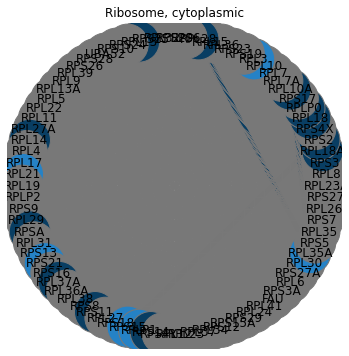

-------------------------
coverage: 0.15384615384615385, complex name: HRD1 complex, id: 6859
{frozenset({'UBBP4|IP_710742', 'ERLIN2'})} ['ERLIN2', 'HSPA5', 'HSP90B1', 'BSG', 'OS9', 'SYVN1', 'FAF2', 'ERLEC1', 'DERL2', 'FAM8A1', 'SEL1L', 'UBE2J1', 'AUP1']


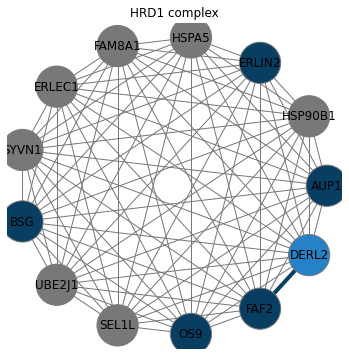

-------------------------
coverage: 0.14893617021276595, complex name: 60S ribosomal subunit, cytoplasmic, id: 308
{frozenset({'RPL23AP29|IP_637308', 'RPL28'}), frozenset({'AL133163.1|IP_747029', 'RPLP0'}), frozenset({'RPL18', 'BEND4|IP_117582'}), frozenset({'RPLP0P2|IP_775646', 'RPLP0'})} ['RPLP1', 'RPLP2', 'RPLP0', 'RPL35A', 'RPL7', 'RPL17', 'RPL13', 'RPL10', 'RPL12', 'RPL9', 'RPL22', 'RPL4', 'RPL3', 'RPL13A', 'RPL35', 'RPL27A', 'RPL5', 'RPL21', 'RPL28', 'RPL29', 'RPL34', 'RPL14', 'RPL26', 'RPL15', 'RPL27', 'RPL37A', 'RPL37', 'RPL7A', 'RPL23A', 'RPL23', 'RPL30', 'RPL39', 'RPL31', 'RPL10A', 'RPL32', 'RPL11', 'RPL8', 'RPL41', 'UBA52', 'RPL38', 'RPL24', 'RPL36A', 'RPL19', 'RPL18A', 'RPL6', 'RPL18', 'RPL36']


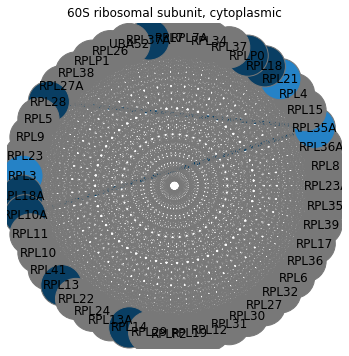

-------------------------
coverage: 0.12903225806451613, complex name: 40S ribosomal subunit, cytoplasmic, id: 338
{frozenset({'RPS2', 'AC004706.3|IP_250569'}), frozenset({'RPS2', 'AL096701.1|IP_651189'}), frozenset({'RPSA', 'RPSAP54|IP_755938'}), frozenset({'RPS2', 'AL139100.1|IP_592636'}), frozenset({'RPSAP2|IP_597202', 'RPSA'})} ['RPS17', 'RPSA', 'RPS2', 'RPS3', 'RPS12', 'RPS19', 'RPS9', 'RPS5', 'RPS10', 'RPS20', 'RPS3A', 'RPS7', 'RPS8', 'RPS15A', 'RPS16', 'RPS14', 'RPS23', 'RPS18', 'RPS29', 'RPS13', 'RPS11', 'RPS4X', 'RPS6', 'RPS15', 'RPS24', 'RPS25', 'RPS26', 'RPS28', 'FAU', 'RPS27A', 'RPS21']


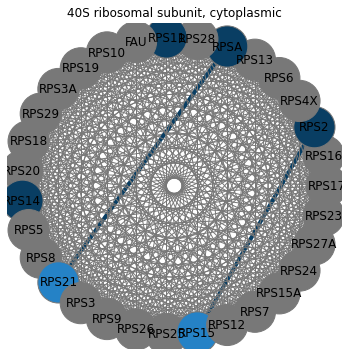

-------------------------
coverage: 0.1, complex name: Large Drosha complex, id: 1332
{frozenset({'LOC643387|IP_635191', 'TARDBP'})} ['DDX3X', 'HNRNPDL', 'DHX15', 'DDX5', 'HNRNPH1', 'FUS', 'HNRNPM', 'HNRNPU', 'EWSR1', 'ILF2', 'ILF3', 'TARDBP', 'DGCR8', 'DDX1', 'TAF15', 'DDX17', 'SRPK1', 'HNRNPUL1', 'DROSHA', 'RALY']


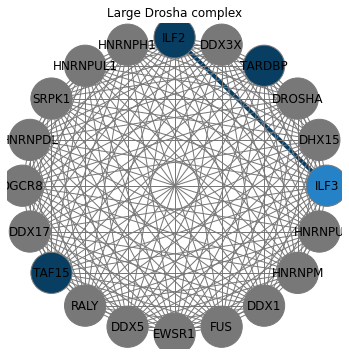

-------------------------
coverage: 0.0, complex name: HMGB1-HMGB2-HSC70-ERP60-GAPDH complex, id: 280
{frozenset({'GAPDHP1|IP_560713', 'GAPDH'}), frozenset({'GAPDH', 'GAPDHP65|IP_557819'}), frozenset({'GAPDH', 'GAPDHP69|IP_755869'}), frozenset({'GAPDH', 'GAPDHP46|IP_672168'}), frozenset({'GAPDH', 'GAPDHP61|IP_735797'}), frozenset({'GAPDH', 'GAPDHP44|IP_761275'}), frozenset({'GAPDH', 'GAPDHP63|IP_591881'})} ['GAPDH', 'HMGB1', 'HSPA8', 'HMGB2', 'PDIA3']


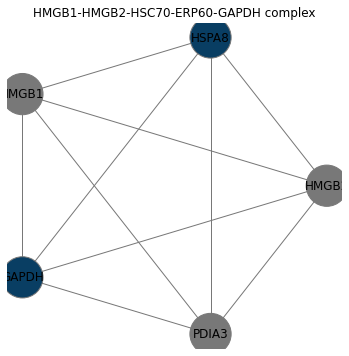

-------------------------
coverage: 0.0, complex name: Ecsit complex (ECSIT, MT-CO2, GAPDH, TRAF6, NDUFAF1), id: 2936
{frozenset({'GAPDHP1|IP_560713', 'GAPDH'}), frozenset({'GAPDH', 'GAPDHP65|IP_557819'}), frozenset({'GAPDH', 'GAPDHP69|IP_755869'}), frozenset({'GAPDH', 'GAPDHP46|IP_672168'}), frozenset({'GAPDH', 'GAPDHP61|IP_735797'}), frozenset({'GAPDH', 'GAPDHP44|IP_761275'}), frozenset({'GAPDH', 'GAPDHP63|IP_591881'})} ['MT-CO2', 'GAPDH', 'ECSIT', 'NDUFAF1', 'TRAF6']


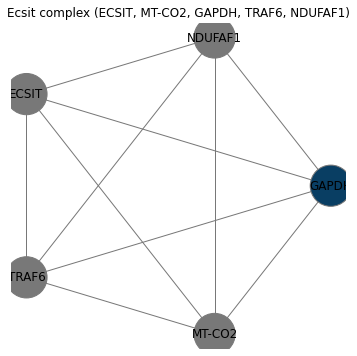

-------------------------
coverage: 0.0, complex name: GAIT complex, id: 5385
{frozenset({'GAPDHP1|IP_560713', 'GAPDH'}), frozenset({'GAPDH', 'GAPDHP65|IP_557819'}), frozenset({'GAPDH', 'GAPDHP69|IP_755869'}), frozenset({'GAPDH', 'GAPDHP46|IP_672168'}), frozenset({'GAPDH', 'GAPDHP61|IP_735797'}), frozenset({'GAPDH', 'GAPDHP44|IP_761275'}), frozenset({'GAPDH', 'GAPDHP63|IP_591881'})} ['SYNCRIP', 'GAPDH', 'EPRS', 'RPL13A']


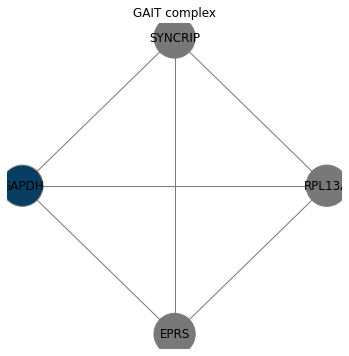

-------------------------
coverage: 0.0, complex name: Frataxin complex, id: 1094
{frozenset({'HSPD1', 'HSPD1P7|IP_658154'}), frozenset({'HSPD1P4|IP_761691', 'HSPD1'}), frozenset({'HSPD1P10|IP_591826', 'HSPD1'}), frozenset({'SNCAIP|IP_130051', 'HSPD1'}), frozenset({'HSPD1P1|IP_603739', 'HSPD1'})} ['ATP5MG', 'HSPD1', 'SDHA', 'HSPA9', 'FXN', 'LYRM4', 'AFG3L2']


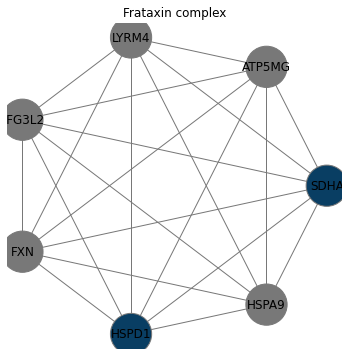

-------------------------
coverage: 0.0, complex name: SNCA-TUBB3 complex, id: 7241
{frozenset({'TUBB3', 'AC068896.1|IP_791587'}), frozenset({'TUBB3', 'TUBB3P1|IP_591777'}), frozenset({'TUBB3', 'TUBB4AP1|IP_557240'}), frozenset({'TUBBP1|IP_572422', 'TUBB3'})} ['SNCA', 'TUBB3']


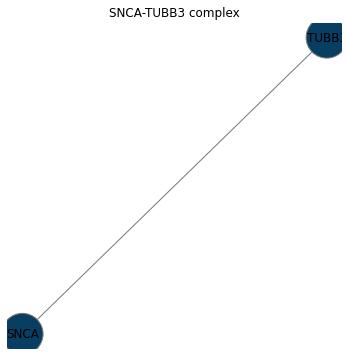

-------------------------
coverage: 0.0, complex name: H2AX complex I, id: 1226
{frozenset({'H2AFX', 'SLC25A29|IP_3406860'}), frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'NPM1', 'NPM1P52|IP_570964'})} ['NPM1', 'PARP1', 'HSPA5', 'H2AFX', 'CALR', 'DHX30', 'HIST3H2BB']


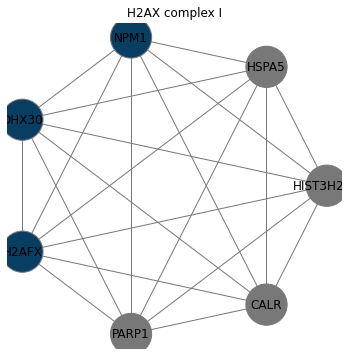

-------------------------
coverage: 0.0, complex name: Emerin complex 25, id: 5613
{frozenset({'BCCIP', 'LINC01910|IP_267348'}), frozenset({'BCCIP', 'AC010677.1|IP_584259'}), frozenset({'BCCIP', 'KLHDC2|IP_751763'})} ['BANF1', 'ZRANB2', 'LSM8', 'SSB', 'LMNB1', 'YWHAB', 'EMD', 'ACTB', 'HNRNPK', 'YWHAE', 'SNRPD1', 'G3BP1', 'CDC37', 'SAP130', 'BCCIP', 'LSM2']


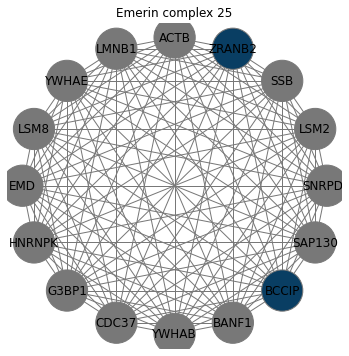

-------------------------
coverage: 0.0, complex name: ABCB1-ANXA2-RACK1-SRC complex, id: 7248
{frozenset({'ANXA2', 'ANXA2P3|IP_789305'}), frozenset({'ANXA2', 'ANXA2P1|IP_3390265'}), frozenset({'ANXA2', 'SYNPR-AS1|IP_113964'})} ['ANXA2', 'ABCB1', 'SRC', 'RACK1']


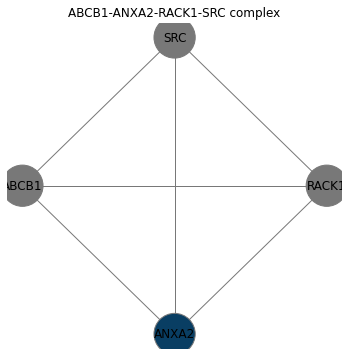

-------------------------
coverage: 0.0, complex name: ARF-Mule complex, id: 220
{frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'NPM1', 'NPM1P52|IP_570964'})} ['NPM1', 'HUWE1', 'CDKN2A']


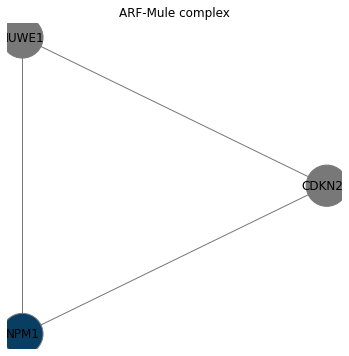

-------------------------
coverage: 0.0, complex name: ESCRT-III complex, id: 1186
{frozenset({'CHMP4A', 'HSPA8P1|IP_557268'}), frozenset({'AC008481.1|IP_691723', 'CHMP5'})} ['CHMP2A', 'CHMP1B', 'CHMP4C', 'CHMP6', 'CHMP4A', 'CHMP4B', 'CHMP1A', 'CHMP5', 'CHMP2B', 'CHMP3']


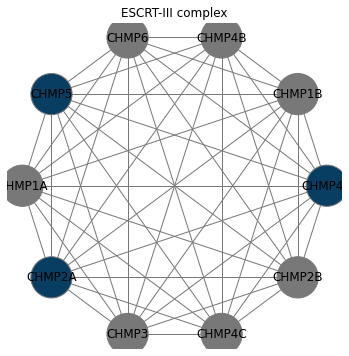

-------------------------
coverage: 0.0, complex name: TLE1 corepressor complex (MASH1 promoter-corepressor complex), id: 1729
{frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'NPM1', 'NPM1P52|IP_570964'})} ['NPM1', 'PARP1', 'NCL', 'HSPA4', 'MYH10', 'ACTB', 'TOP2B', 'TLE1', 'NONO', 'RAD50']


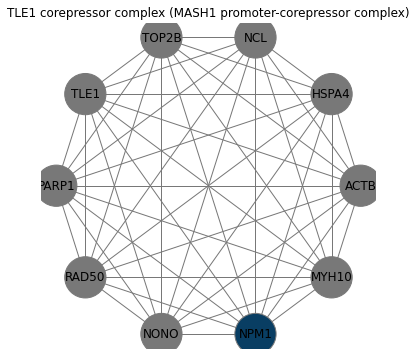

-------------------------
coverage: 0.0, complex name: TLE1 corepressor complex (MASH1 promoter-corepressor complex), id: 3135
{frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'NPM1', 'NPM1P52|IP_570964'})} ['NPM1', 'PARP1', 'NCL', 'HSPA4', 'TOP2B', 'TLE1', 'NONO', 'RAD50']


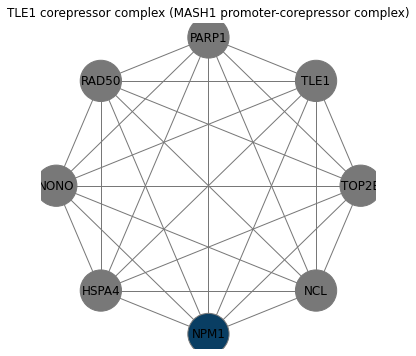

-------------------------
coverage: 0.0, complex name: GammaH2AFX-NDHII-Ku70-DNA complex, id: 3618
{frozenset({'H2AFX', 'SLC25A29|IP_3406860'}), frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['XRCC6', 'H2AFX', 'DHX9']


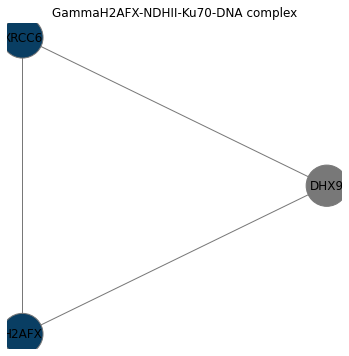

-------------------------
coverage: 0.0, complex name: CTCF-nucleophosmin complex, id: 5154
{frozenset({'NPM1P19|IP_662403', 'NPM1'}), frozenset({'NPM1', 'NPM1P52|IP_570964'})} ['NPM1', 'CTCF']


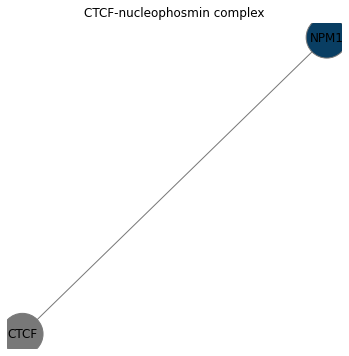

-------------------------
coverage: 0.0, complex name: DNAAF2-HEATR2-SPAG1 complex, id: 7100
{frozenset({'AL391419.1|IP_556791', 'DNAAF2'}), frozenset({'FMO5|IP_669446', 'DNAAF2'})} ['SPAG1', 'DNAAF5', 'DNAAF2']


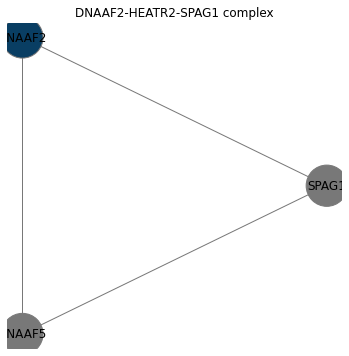

-------------------------
coverage: 0.0, complex name: GSKIP-PRKAR2B complex, id: 7129
{frozenset({'PRKAR2B', 'PRKAR2B|IP_156019'}), frozenset({'PRKAR2B', 'ATRX|IP_301371'})} ['PRKAR2B', 'GSKIP']


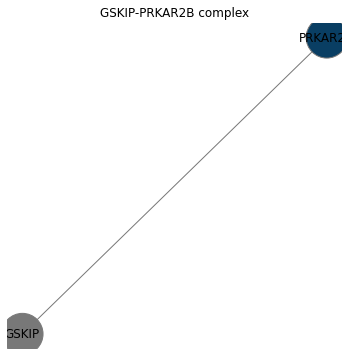

-------------------------
coverage: 0.0, complex name: PA28gamma complex, id: 29
{frozenset({'PSME3', 'BEND4|IP_117582'})} ['PSME3']


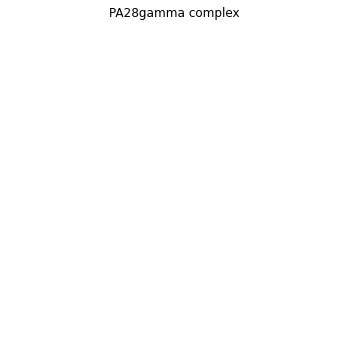

-------------------------
coverage: 0.0, complex name: FCP1-associated protein complex, id: 811
{frozenset({'WDR77', 'CCT6P4|IP_620044'})} ['PRMT5', 'POLR2B', 'GTF2F1', 'ERH', 'STK38', 'WDR77', 'CTDP1']


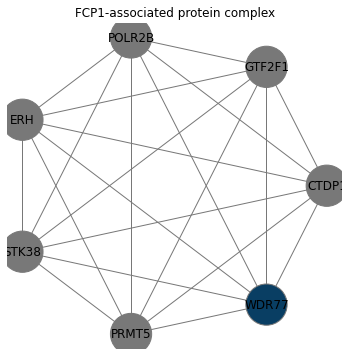

-------------------------
coverage: 0.0, complex name: RC complex (Replication competent complex), id: 1003
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['POLA1', 'CCNA2', 'CDK2', 'RFC4', 'RFC2', 'RFC1', 'RFC5', 'RFC3', 'POLA2']


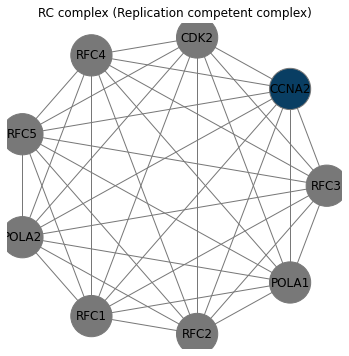

-------------------------
coverage: 0.0, complex name: P-TEFb.4 complex, id: 1083
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['CCNK', 'CDK9']


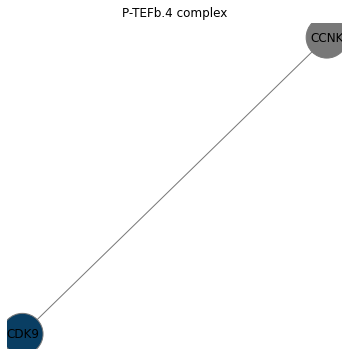

-------------------------
coverage: 0.0, complex name: RNA pol II containing coactivator complex Tat-SF, id: 1191
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['SUPT5H', 'HTATSF1', 'NCL', 'POLR2A', 'CDK9']


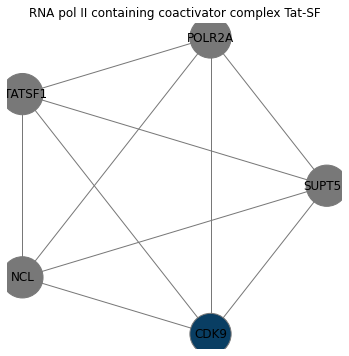

-------------------------
coverage: 0.0, complex name: CASP8-FADD-MALT1-BCL10 complex, id: 2054
{frozenset({'FADD|IP_198808', 'FADD'})} ['BCL10', 'FADD', 'CASP8', 'MALT1']


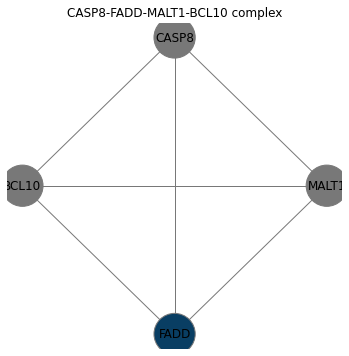

-------------------------
coverage: 0.0, complex name: MDC1-H2AFX-TP53BP1 complex, id: 2774
{frozenset({'H2AFX', 'SLC25A29|IP_3406860'})} ['H2AFX', 'TP53BP1', 'MDC1']


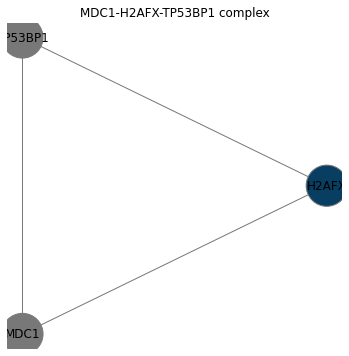

-------------------------
coverage: 0.0, complex name: OCT4-SOX2 DNA-protein complex, id: 2801
{frozenset({'ENO1P1|IP_079312', 'SOX2'})} ['SOX2', 'POU5F1']


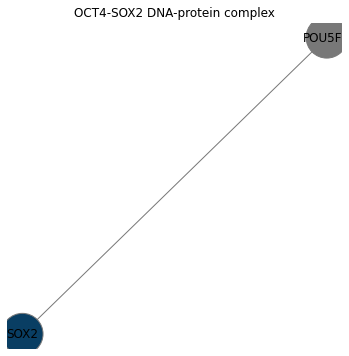

-------------------------
coverage: 0.0, complex name: OCT1-SOX2 DNA-protein complex, id: 2802
{frozenset({'ENO1P1|IP_079312', 'SOX2'})} ['POU2F1', 'SOX2']


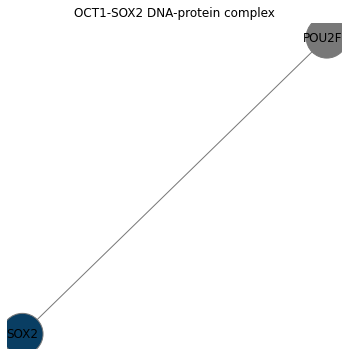

-------------------------
coverage: 0.0, complex name: PAX6-SOX2 DNA-protein complex, id: 2803
{frozenset({'ENO1P1|IP_079312', 'SOX2'})} ['PAX6', 'SOX2']


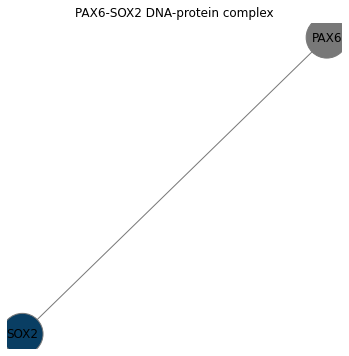

-------------------------
coverage: 0.0, complex name: BRCA1-VCP complex, id: 2820
{frozenset({'VCP', 'EEA1|IP_765964'})} ['BRCA1', 'VCP']


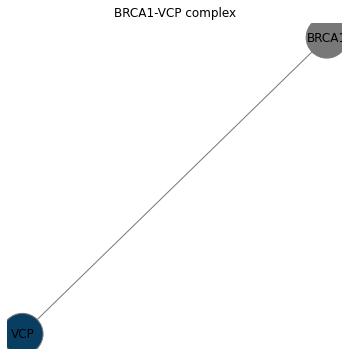

-------------------------
coverage: 0.0, complex name: Profilin 1 complex, id: 2837
{frozenset({'VCP', 'EEA1|IP_765964'})} ['PFN1', 'HSPA8', 'VCP', 'ACTG1', 'CLTC', 'TUBB2B']


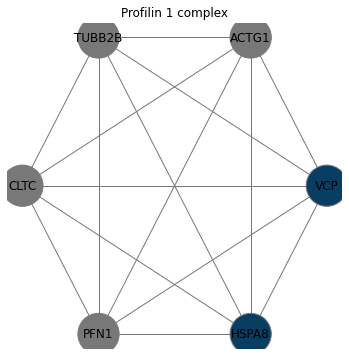

-------------------------
coverage: 0.0, complex name: MEP50-PRMT5-ICLN complex, id: 2838
{frozenset({'WDR77', 'CCT6P4|IP_620044'})} ['PRMT5', 'CLNS1A', 'WDR77']


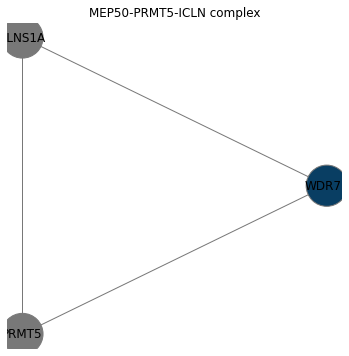

-------------------------
coverage: 0.0, complex name: FHL3 homodimer complex, id: 3184
{frozenset({'C2orf71|IP_084200', 'FHL3'})} ['FHL3']


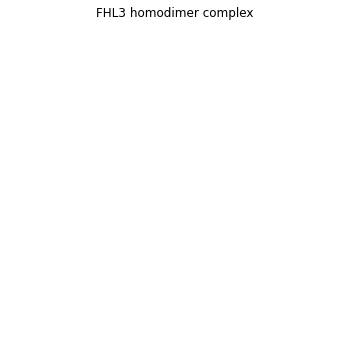

-------------------------
coverage: 0.0, complex name: FHL2-FHL3 complex, id: 3187
{frozenset({'C2orf71|IP_084200', 'FHL3'})} ['FHL3', 'FHL2']


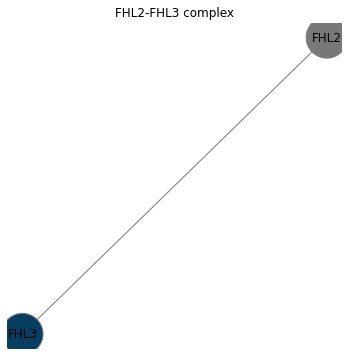

-------------------------
coverage: 0.0, complex name: FHL3-CREB complex, id: 3190
{frozenset({'C2orf71|IP_084200', 'FHL3'})} ['CREB1', 'FHL3']


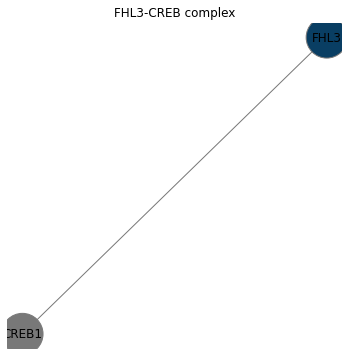

-------------------------
coverage: 0.0, complex name: CDK9-IL6ST complex, id: 3229
{frozenset({'HSP90AA4P|IP_610386', 'CDK9'})} ['IL6ST', 'CDK9']


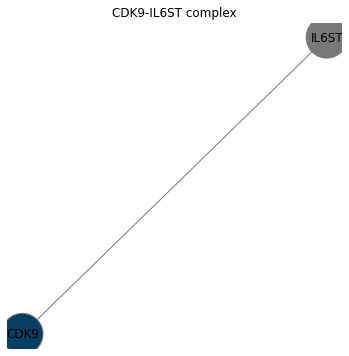

-------------------------
coverage: 0.0, complex name: SVIP-VCP-DERL1 complex, id: 4976
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'SVIP', 'DERL1']


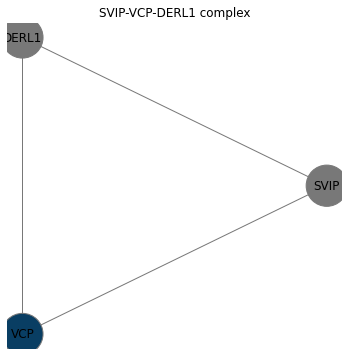

-------------------------
coverage: 0.0, complex name: gp78-VCP-DERL1 complex, id: 4977
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'DERL1', 'AMFR']


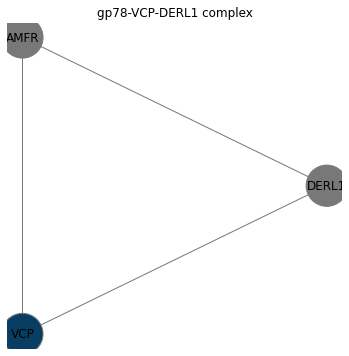

-------------------------
coverage: 0.0, complex name: VCP-VIMP-DERL1 complex, id: 4997
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'SELENOS', 'DERL1']


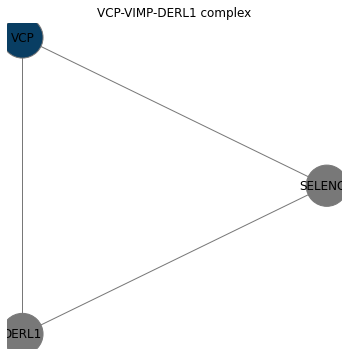

-------------------------
coverage: 0.0, complex name: VCP-VIMP-DERL2 complex, id: 4998
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'SELENOS', 'DERL2']


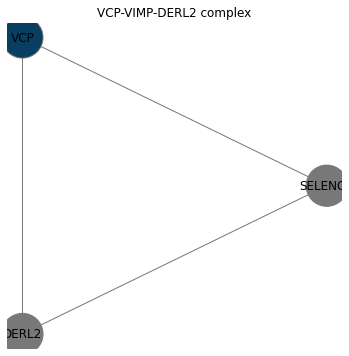

-------------------------
coverage: 0.0, complex name: VCP-VIMP-DERL1-DERL2-HRD1-SEL1L complex, id: 4999
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'SYVN1', 'SELENOS', 'DERL1', 'DERL2', 'SEL1L']


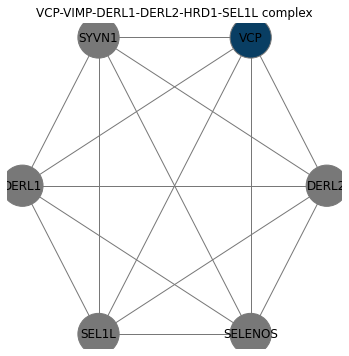

-------------------------
coverage: 0.0, complex name: P53-BARD1-KU70 complex, id: 5288
{frozenset({'XRCC6P1|IP_788703', 'XRCC6'})} ['TP53', 'XRCC6', 'BARD1']


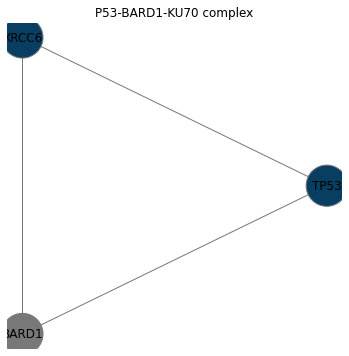

-------------------------
coverage: 0.0, complex name: SERPINA3-CTSG complex, id: 5389
{frozenset({'SERPINA3', 'LOC107986256|IP_2361361'})} ['SERPINA3', 'CTSG']


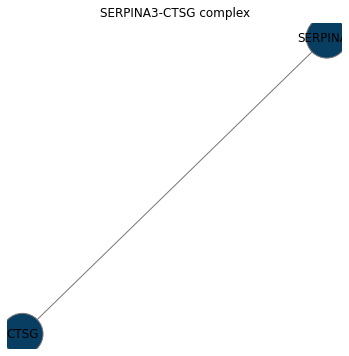

-------------------------
coverage: 0.0, complex name: Ternary complex (TRAF2, FADD, TRADD), id: 5541
{frozenset({'FADD|IP_198808', 'FADD'})} ['TRAF2', 'FADD', 'TRADD']


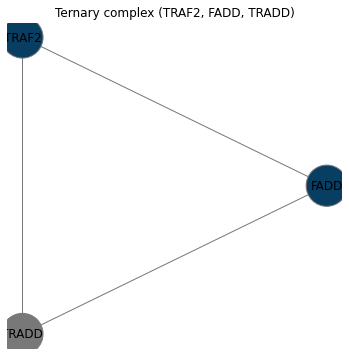

-------------------------
coverage: 0.0, complex name: CDK2-CCNA2 complex, id: 5556
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['CCNA2', 'CDK2']


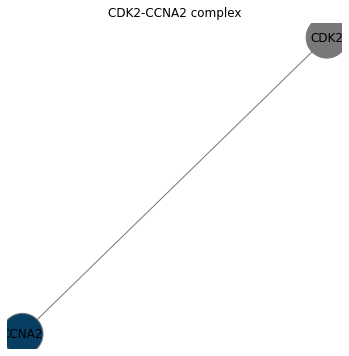

-------------------------
coverage: 0.0, complex name: CDC2-CCNA2 complex, id: 5557
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['CDK1', 'CCNA2']


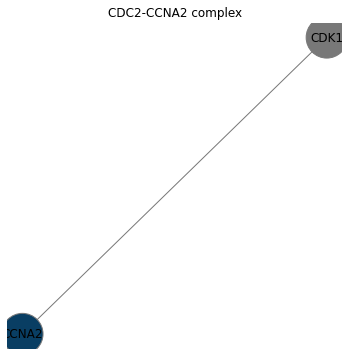

-------------------------
coverage: 0.0, complex name: CDC2-CCNA2-CDK2 complex, id: 5559
{frozenset({'ALPK3|IP_236856', 'CCNA2'})} ['CDK1', 'CCNA2', 'CDK2']


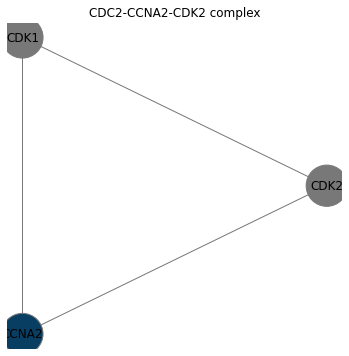

-------------------------
coverage: 0.0, complex name: Membrane protein complex (VCP, UFD1L, SEC61B), id: 5685
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'SEC61B', 'UFD1']


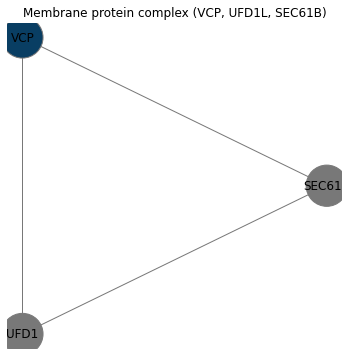

-------------------------
coverage: 0.0, complex name: Death induced signaling complex II (FADD, CASP8, CFLAR), cytosolic, CD95L induced, id: 5798
{frozenset({'FADD|IP_198808', 'FADD'})} ['CFLAR', 'FADD', 'CASP8']


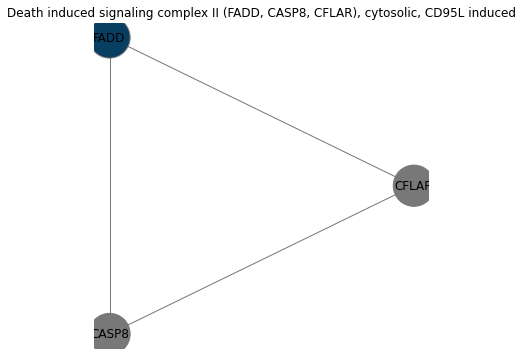

-------------------------
coverage: 0.0, complex name: PPP2R1A-PPP2R1B-PPP2CA-PPME1-EIF4A1 complex, id: 5876
{frozenset({'EIF4A1', 'EIF4A1P7|IP_758374'})} ['PPP2R1A', 'PPP2R1B', 'EIF4A1', 'PPP2CA', 'PPME1']


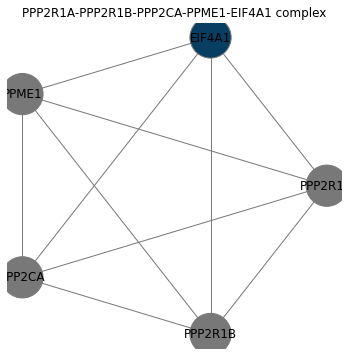

-------------------------
coverage: 0.0, complex name: LRRK2-FADD-CASP8 complex, id: 5991
{frozenset({'FADD|IP_198808', 'FADD'})} ['FADD', 'CASP8', 'LRRK2']


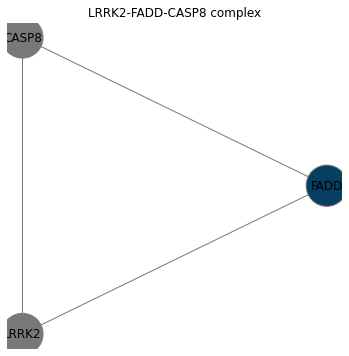

-------------------------
coverage: 0.0, complex name: proMBP-angiotensinogen complex, id: 6103
{frozenset({'AGT', 'HSPA8P16|IP_581325'})} ['AGT', 'PRG2']


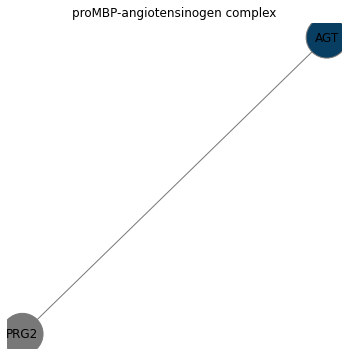

-------------------------
coverage: 0.0, complex name: proMBP-angiotensinogen-c3dg complex, id: 6107
{frozenset({'AGT', 'HSPA8P16|IP_581325'})} ['AGT', 'C3', 'PRG2']


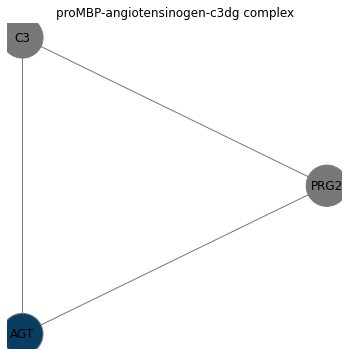

-------------------------
coverage: 0.0, complex name: prohibitin 2 complex, mitochondrial, id: 6289
{frozenset({'PHB', 'PHBP19|IP_762813'})} ['HAX1', 'SLC25A5', 'PHB', 'VDAC2', 'PHB2']


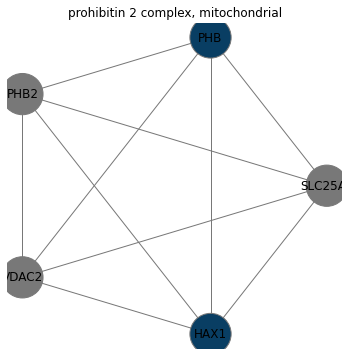

-------------------------
coverage: 0.0, complex name: RIPK1-FADD-caspase-8 complex, id: 6414
{frozenset({'FADD|IP_198808', 'FADD'})} ['FADD', 'RIPK1', 'CASP8']


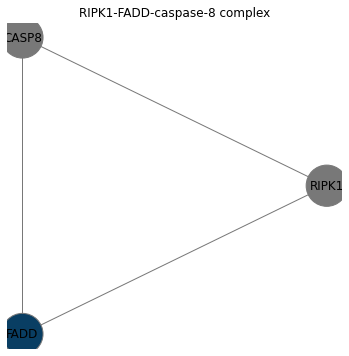

-------------------------
coverage: 0.0, complex name: TTN-TCAP complex, id: 6432
{frozenset({'TCAP', 'HSPA8P1|IP_557270'})} ['TCAP', 'TTN']


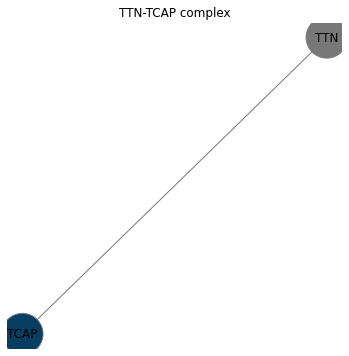

-------------------------
coverage: 0.0, complex name: erlin1/2-RNF170 complex, id: 6476
{frozenset({'UBBP4|IP_710742', 'ERLIN2'})} ['ERLIN1', 'ERLIN2', 'RNF170']


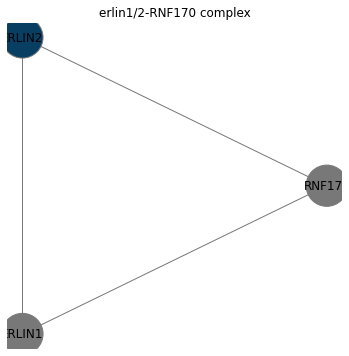

-------------------------
coverage: 0.0, complex name: Ubiquilin-VCP-erasin complex, id: 6523
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'UBXN4', 'UBQLN1']


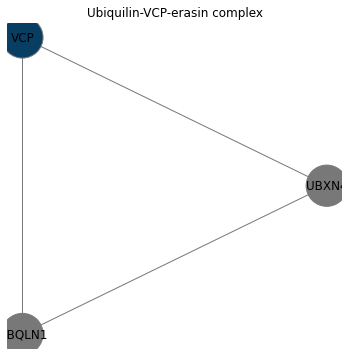

-------------------------
coverage: 0.0, complex name: CHRNA9-CHRNA10 complex, id: 6584
{frozenset({'LINC01123|IP_099004', 'CHRNA9'})} ['CHRNA10', 'CHRNA9']


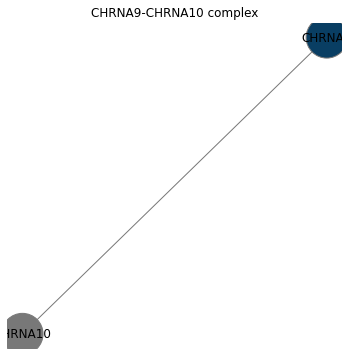

-------------------------
coverage: 0.0, complex name: CLIC5A-EZR-PODXL complex, id: 6783
{frozenset({'PTPN20|IP_2320285', 'CLIC5'})} ['PODXL', 'EZR', 'CLIC5']


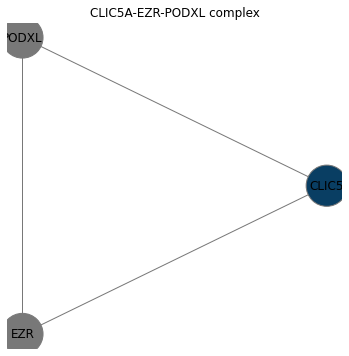

-------------------------
coverage: 0.0, complex name: FGF19-FGFR4-KLB complex, heparin induced, id: 6832
{frozenset({'C11orf65|IP_2311662', 'FGF19'})} ['FGF19', 'FGFR4', 'KLB']


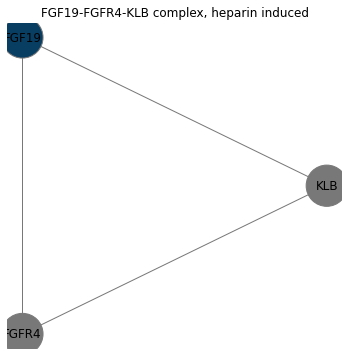

-------------------------
coverage: 0.0, complex name: CHTOP-methylosome complex, id: 6858
{frozenset({'WDR77', 'CCT6P4|IP_620044'})} ['PRMT5', 'ERH', 'PRMT1', 'WDR77', 'CHTOP']


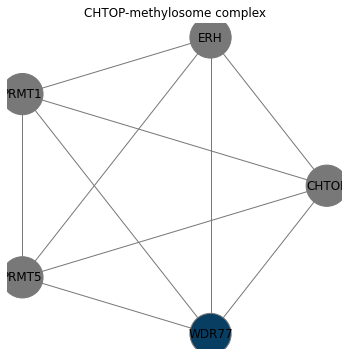

-------------------------
coverage: 0.0, complex name: AMFR-ERLIN2-TMUB1 complex, id: 6866
{frozenset({'UBBP4|IP_710742', 'ERLIN2'})} ['ERLIN2', 'TMUB1', 'AMFR']


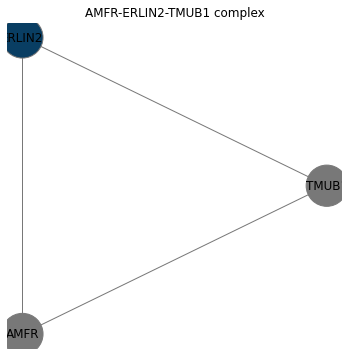

-------------------------
coverage: 0.0, complex name: FERMT3-RACK1 complex, id: 7011
{frozenset({'FERMT3', 'KCNJ2-AS1|IP_262843'})} ['RACK1', 'FERMT3']


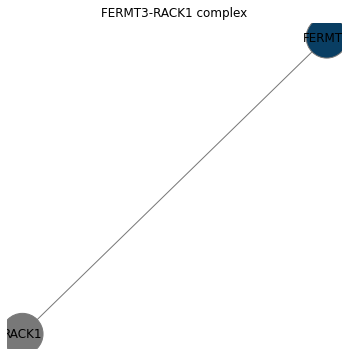

-------------------------
coverage: 0.0, complex name: ASAH1-NR5A1 complex, id: 7098
{frozenset({'RPL23AP32|IP_639798', 'ASAH1'})} ['NR5A1', 'ASAH1']


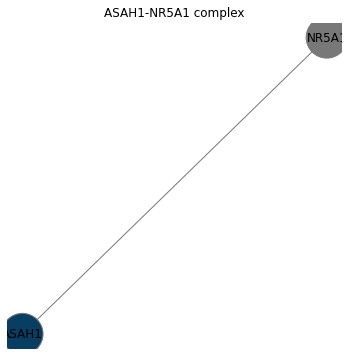

-------------------------
coverage: 0.0, complex name: ASAH1-NR5A1-SAPD complex, id: 7099
{frozenset({'RPL23AP32|IP_639798', 'ASAH1'})} ['PSAP', 'NR5A1', 'ASAH1']


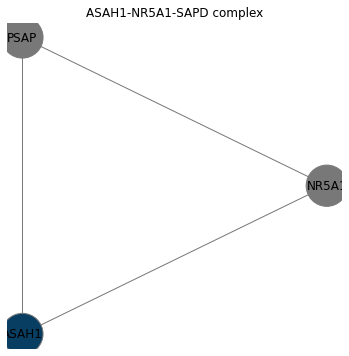

-------------------------
coverage: 0.0, complex name: SOX2-VRK1 complex, id: 7102
{frozenset({'ENO1P1|IP_079312', 'SOX2'})} ['SOX2', 'VRK1']


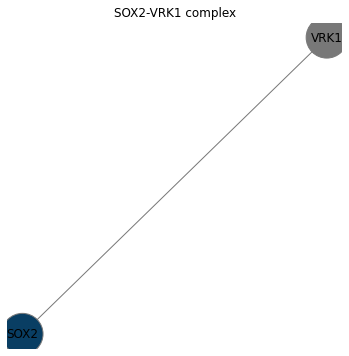

-------------------------
coverage: 0.0, complex name: VCP-SELK-DERL1 complex, id: 7136
{frozenset({'VCP', 'EEA1|IP_765964'})} ['VCP', 'DERL1', 'SELENOK']


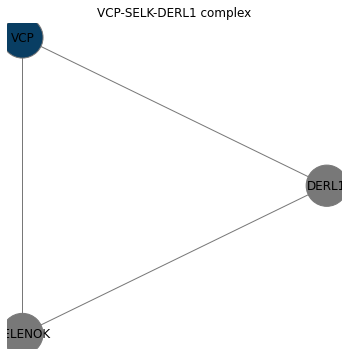

-------------------------
coverage: 0.0, complex name: BRD7-BAF60A-MEP50 complex, id: 7374
{frozenset({'WDR77', 'CCT6P4|IP_620044'})} ['SMARCD1', 'WDR77', 'BRD7']


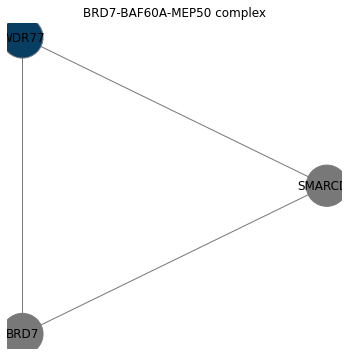

-------------------------
coverage: 0.0, complex name: Prohibitin-HIRA complex, id: 7382
{frozenset({'PHB', 'PHBP19|IP_762813'})} ['PHB', 'HIRA', 'UBN1', 'CABIN1']


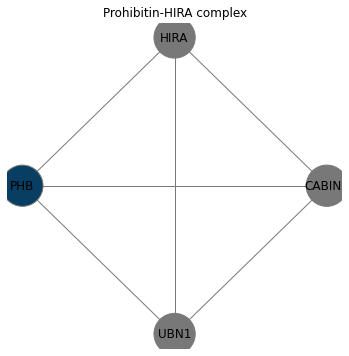

-------------------------
coverage: 0.0, complex name: Potassium channel complex (KCNA1, KCNA2, KCNAB2), id: 7389
{frozenset({'CEP83-DT|IP_218061', 'KCNAB2'})} ['KCNA2', 'KCNA1', 'KCNAB2']


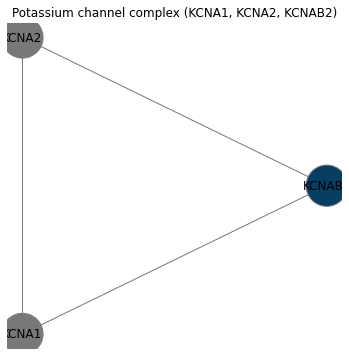

-------------------------
coverage: 0.0, complex name: Astrin-kinastrin complex, id: 7479
{frozenset({'PLK1', 'ARHGAP29|IP_067162'})} ['PLK1', 'DYNLL1', 'SGO2', 'SPAG5', 'KNSTRN']


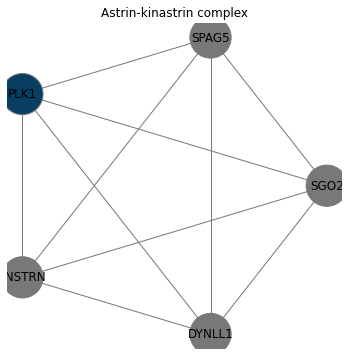

-------------------------


In [13]:
for complx in sorted([x for x in corum if len(x['alt_edges'])>0], key=lambda x: [-x['coverage'], -len(x['alt_edges'])]):
    print('coverage: {}, complex name: {}, id: {}'.format(complx['coverage'], complx['ComplexName'], complx['ComplexID']))
    print(complx['alt_edges'], complx['subunits (HGNC)'])
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    ax.set_title(complx['ComplexName'])
    
    pairwise_complx = set(frozenset((b, p)) for b, p in itt.permutations(complx['subunits (HGNC)'], 2))
    
    write_corum_edges(pairwise_complx, complx['alt_edges'], complx['ComplexID'])
    
    G = nx.Graph(list(pairwise_complx))
    draw_circ_layout_complx(G, G_o_edges, HCIP_baits, ax)
    plt.savefig('bioplex_figures/CORUM/{}.svg'.format(complx['ComplexID']))
    plt.show()
    print('-------------------------')